# EDA & Feature Selection: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [1303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

from pandas import Series, DataFrame
from numpy.random import choice
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE


np.set_printoptions(suppress=True)

sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
sns.set_palette("Set2")
warnings.filterwarnings('ignore')

# Data

In [1304]:
df_raw_data = pd.read_csv("../data/data.csv")
df = df_raw_data.copy()
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Helper Functions & Constants

In [1305]:
# Columns
PID = "PassengerId"
HOME_PLANET = "HomePlanet"
CRYO_SLEEP = "CryoSleep"
CABIN = "Cabin"
DESTINATION = "Destination"
AGE = "Age"
VIP = "VIP"
ROOM_SERVICE = "RoomService"
FOOD_COURT = "FoodCourt"
SHOPPING_MALL = "ShoppingMall"
SPA = "Spa"
VR_DECK = "VRDeck"
NAME = "Name"
TARGET_TRANSPORTED = "Transported"

# Added Columns
TARGET = "Target"
VIP_CAT = "VIPCat"
CRYO_SLEEP_CAT = "CryoSleepCat"
PAYMENTS = "Payments"

# Constants
NUM_COLUMNS = df.describe().columns             # DEVTED
TRUE_FALSE_MAP = {False: 0, True: 1}            # DEVTED
TRUE_FALSE_MAP_REVERSE = {0: False, 1: True}    # DEVTED


In [1306]:
df[TARGET] = df[TARGET_TRANSPORTED].map(TRUE_FALSE_MAP)
df[CRYO_SLEEP_CAT] = df[CRYO_SLEEP]
df[CRYO_SLEEP] = df[CRYO_SLEEP].map(TRUE_FALSE_MAP)
df[VIP_CAT] = df[VIP]
df[VIP] = df[VIP].map(TRUE_FALSE_MAP)

display(
    df[TARGET_TRANSPORTED].value_counts(dropna=False),
    df[TARGET].value_counts(dropna=False),
    df[CRYO_SLEEP_CAT].value_counts(dropna=False),
    df[CRYO_SLEEP].value_counts(dropna=False),
    df[VIP_CAT].value_counts(dropna=False),
    df[VIP].value_counts(dropna=False)
)
df[TARGET].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

1    4378
0    4315
Name: Target, dtype: int64

False    5439
True     3037
NaN       217
Name: CryoSleepCat, dtype: int64

0.0    5439
1.0    3037
NaN     217
Name: CryoSleep, dtype: int64

False    8291
NaN       203
True      199
Name: VIPCat, dtype: int64

0.0    8291
NaN     203
1.0     199
Name: VIP, dtype: int64

1    4378
0    4315
Name: Target, dtype: int64

In [1307]:
def plot_target_relation(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    target_pvt = df.pivot_table(index=column_name, values=TARGET, aggfunc="mean").sort_index()

    sns.pointplot(x=TARGET_TRANSPORTED, y=column_name, data=df, ax=ax1).set_title(f"Relation Transported and {column_name}")
    sns.regplot(x=target_pvt.index, y=target_pvt.to_numpy(), ci=False, line_kws={"color": "C1"}, scatter_kws={"alpha": 0.5}, ax=ax2).set_title(f"Linear Relation Transported and {column_name}")

def plot_target_relation_cat(column_name):
    g = sns.pointplot(x=column_name, y=TARGET, data=df)
    g.set_title(f"Relation Transported and {column_name}")
    g.tick_params(axis='x', rotation=45)

def plot_dist(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    title = f"Distribution of {column_name}"
    ax1.set_title(title)
    ax2.set_title(title)

    sns.boxplot(x=column_name, data=df, ax=ax1)
    df[column_name].hist(ax=ax2)

    print(f"Skew: \t {df[column_name].skew()}")

def plot_dist_cat(column_name):
    g = sns.countplot(x=column_name, data=df, color="C0")
    g.tick_params(axis='x', rotation=45)
    g.set_title(f"Distribution of {column_name}")

# Data Cleaning & Preprocessing

In [1308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Target        8693 non-null   int64  
 15  CryoSleepCat  8476 non-null   object 
 16  VIPCat        8490 non-null   object 
dtypes: bool(1), float64(8), int64(1), object(7)
memory usage: 1.1+ MB


In [1309]:
df.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [1310]:
df.describe(include=["O"])

,PassengerId,HomePlanet,Cabin,Destination,Name,CryoSleepCat,VIPCat
count,8693,8492,8494,8511,8493,8476,8490
unique,8693,3,6560,3,8473,2,2
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Gollux Reedall,False,False
freq,1,4602,8,5915,2,5439,8291


In [1311]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Target            0
CryoSleepCat    217
VIPCat          203
dtype: int64

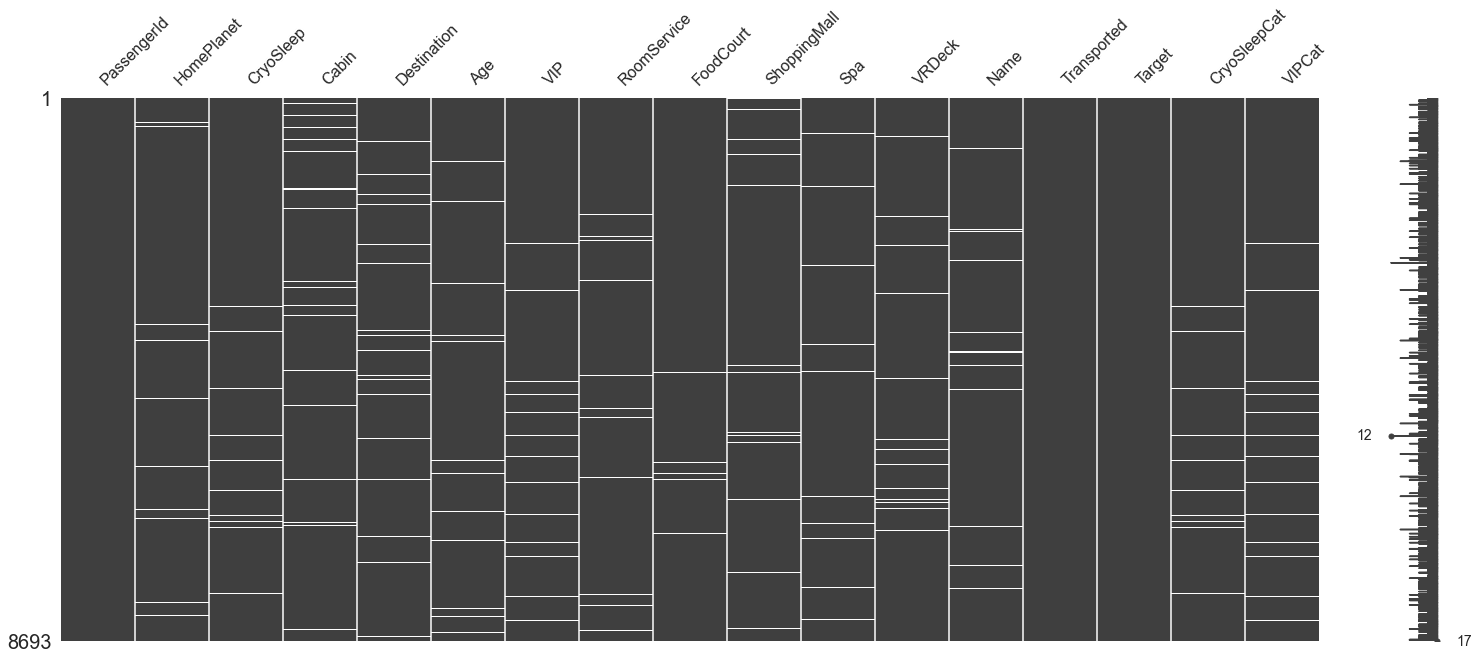

In [1312]:
msno.matrix(df);

Can't find any missing-patterns between the features.

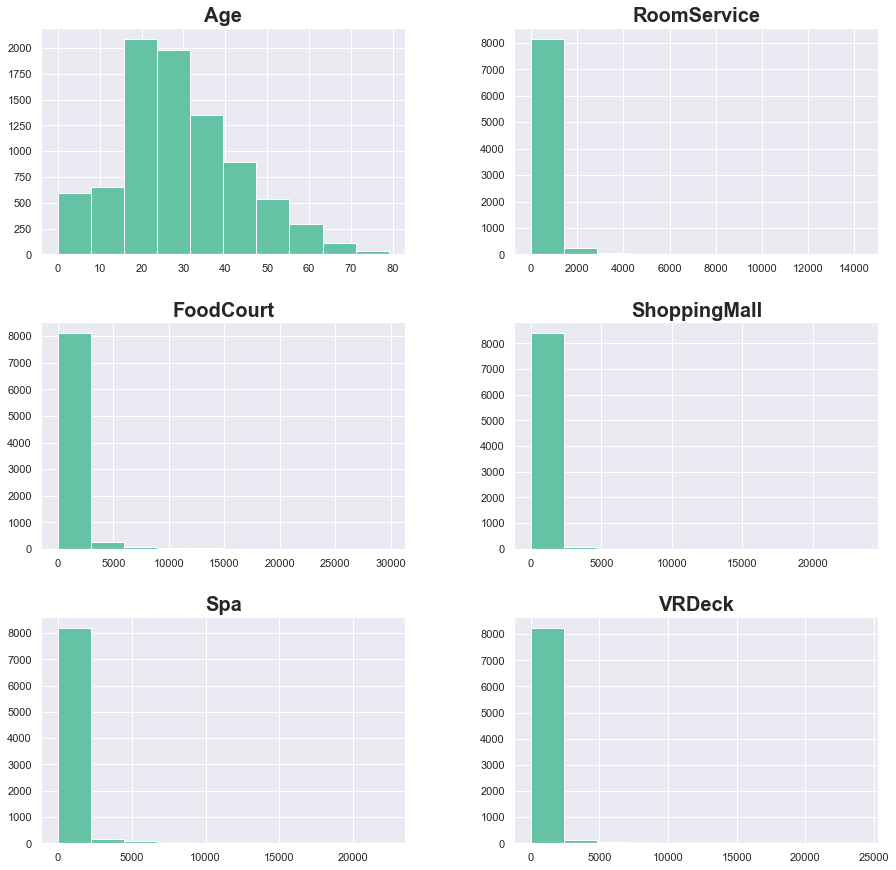

In [1313]:
df[NUM_COLUMNS].hist(figsize=(15, 15));

Age is normal distributed, the other features are very skew.

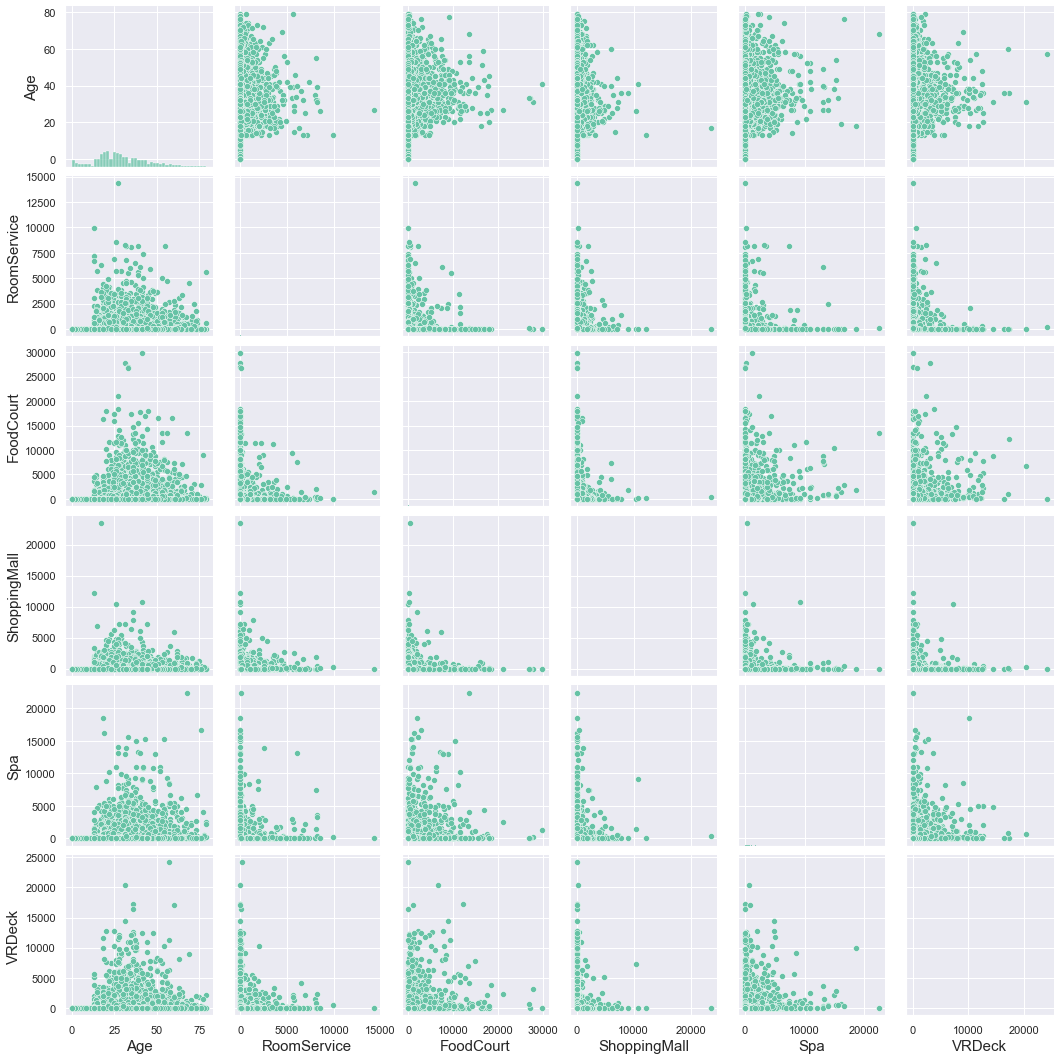

In [1314]:
sns.pairplot(df[NUM_COLUMNS]);

In [1315]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Target,CryoSleepCat,VIPCat
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,False,False
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,False,False
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,False,True
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,False,False
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0.0,A/98/P,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,0,False,True
8689,9278_01,Earth,1.0,G/1499/S,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0,True,False
8690,9279_01,Earth,0.0,G/1500/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1,False,False
8691,9280_01,Europa,0.0,E/608/S,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,0,False,False


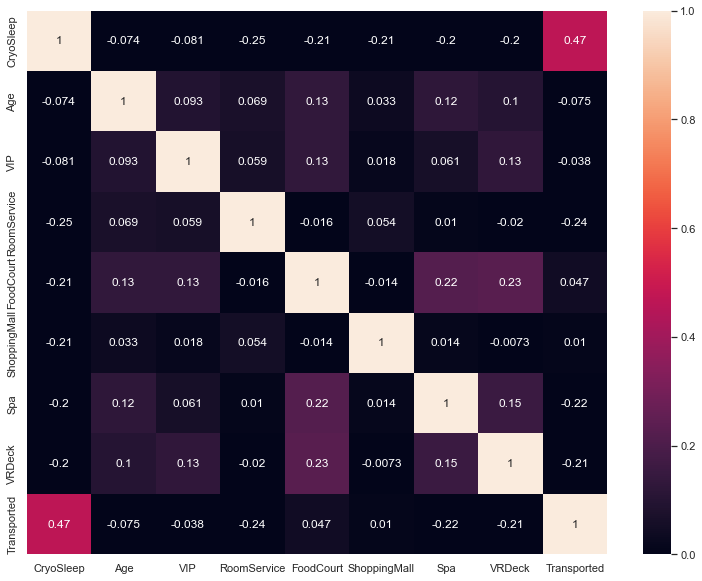

In [1316]:
plt.figure(figsize=(13, 10))
sns.heatmap(df.drop(columns=[TARGET]).corr(), vmin=0, vmax=1, annot=True);

Only the feature CryoSleep got a higher correlation with the target. The other features hasn't got an significant correlation between the target or the other features.

# Exploring & Cleaning the Data

## Drop features

In [1317]:
df.drop(columns=[PID, NAME], inplace=True)
df.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,1,False,False


The name and the PID are unnecessary for our EDA, because they are (nearly) unique and qualitative features.

## Target | Transported

In [1318]:
display(
    df[TARGET].value_counts(),
    df[TARGET_TRANSPORTED].value_counts()
)

1    4378
0    4315
Name: Target, dtype: int64

True     4378
False    4315
Name: Transported, dtype: int64

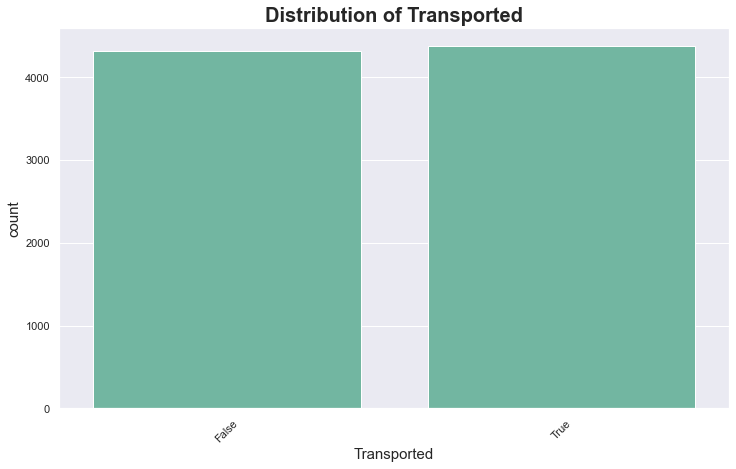

In [1319]:
plot_dist_cat(TARGET_TRANSPORTED)

In [1320]:
###############################################################
#   Oversample the target (BorderlineSMOTE)
###############################################################

## General Preprocessing

In [1321]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,1,False,False
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False,0,False,True
3,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False,0,False,False
4,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,True,1,False,False


In [1322]:
df[CABIN].str[0].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [1323]:
df[CABIN] = df[CABIN].str[0]
df[CABIN].value_counts(dropna=False)

F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: Cabin, dtype: int64

In [1324]:
df[DESTINATION].value_counts(dropna=False)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64

In [1325]:
def set_payments_to_zero(column_name):
    df.loc[df[column_name].isna(), column_name] = 0
    
set_payments_to_zero(ROOM_SERVICE)
set_payments_to_zero(FOOD_COURT)
set_payments_to_zero(SHOPPING_MALL)
set_payments_to_zero(SPA)
set_payments_to_zero(VR_DECK)

df.isna().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Target            0
CryoSleepCat    217
VIPCat          203
dtype: int64

## HomePlanet

### Overview

In [1326]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
0,Europa,0.0,B,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
1,Earth,0.0,F,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,1,False,False
2,Europa,0.0,A,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False,0,False,True
3,Europa,0.0,A,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False,0,False,False
4,Earth,0.0,F,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,True,1,False,False


In [1327]:
df[HOME_PLANET].isna().sum()

201

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

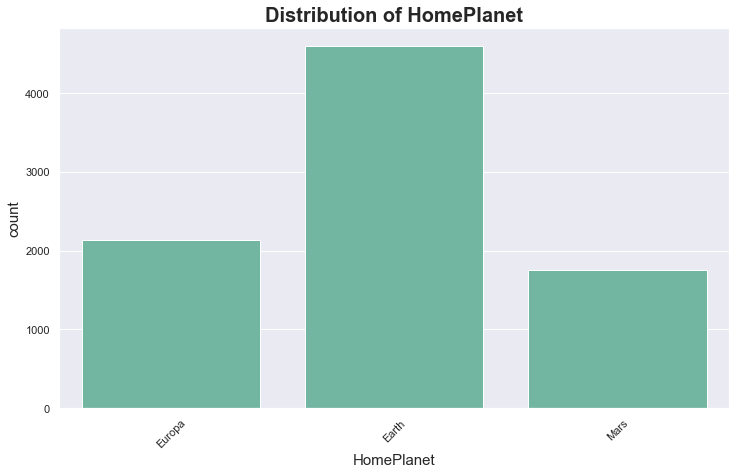

In [1328]:
plot_dist_cat(HOME_PLANET)
df[HOME_PLANET].value_counts()

,Target
HomePlanet,
Earth,0.423946
Europa,0.658846
Mars,0.523024


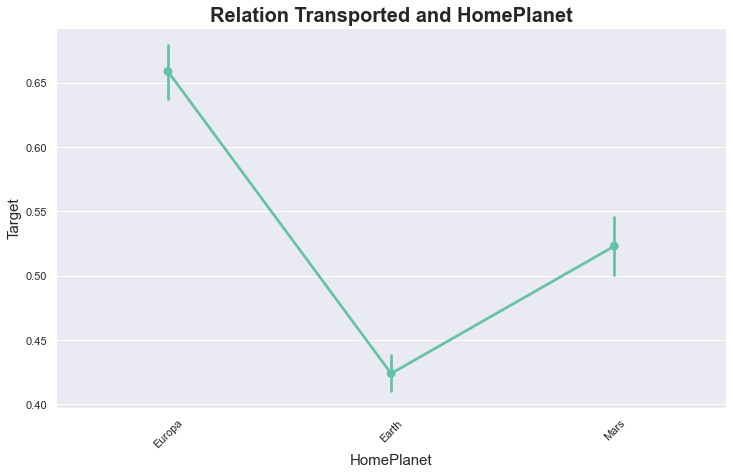

In [1329]:
plot_target_relation_cat(HOME_PLANET)
df.pivot_table(index=HOME_PLANET, values=TARGET)

### HomePlanet by Cabin

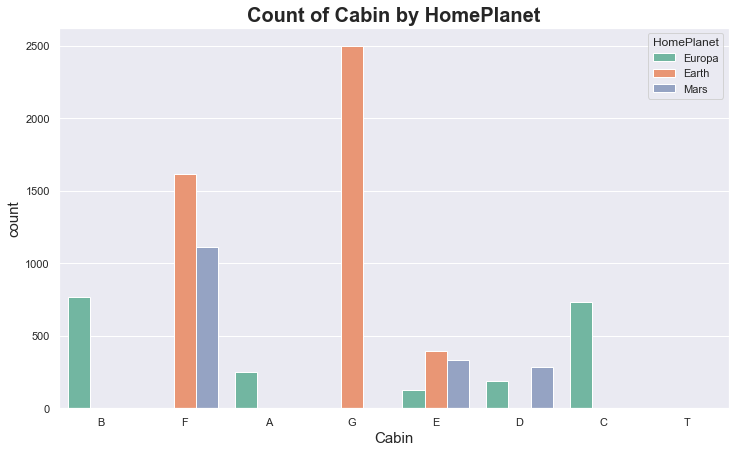

In [1330]:
sns.countplot(x=CABIN, hue=HOME_PLANET, data=df).set(title="Count of Cabin by HomePlanet");

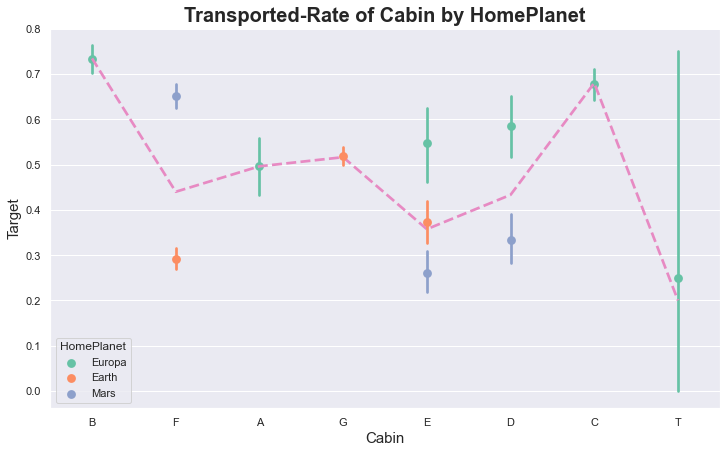

In [1331]:
sns.pointplot(x=CABIN, y=TARGET, ci=None, markers="", linestyles="--", color="C3", data=df)
sns.pointplot(x=CABIN, y=TARGET, data=df, hue=HOME_PLANET, linestyles="").set(title="Transported-Rate of Cabin by HomePlanet");

Notice: 
- B & C only Europa
- G primary Earth

### HomePlanet by CryoSleep

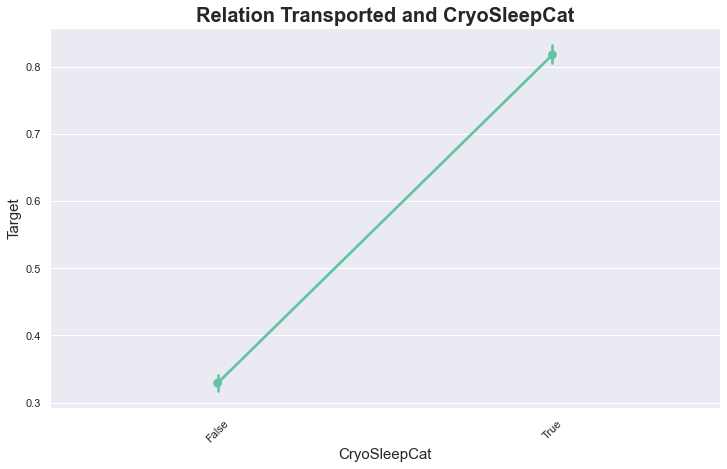

In [1332]:
plot_target_relation_cat(CRYO_SLEEP_CAT)

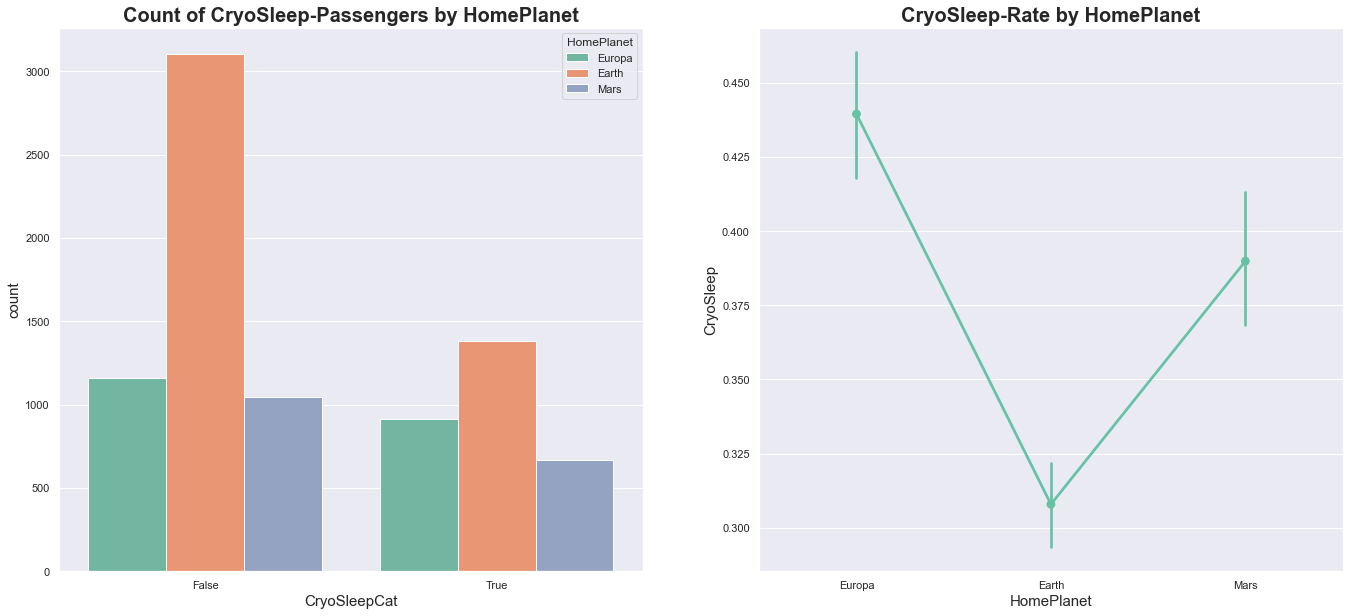

In [1333]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))
ax1, ax2 = axes

ax1.set_title("Count of CryoSleep-Passengers by HomePlanet")
ax2.set_title("CryoSleep-Rate by HomePlanet")

sns.countplot(x=CRYO_SLEEP_CAT, hue=HOME_PLANET, data=df, ax=ax1)
sns.pointplot(x=HOME_PLANET, y=CRYO_SLEEP, data=df, ax=ax2);

Notice:
- when you are in CryoSleep, the probability to be transported is more then 2 times higher
- Europa-Passengers are significant more in CryoSleep, and Earth-Passengers are significant less in CryoSleep 

### HomePlanet by Destination

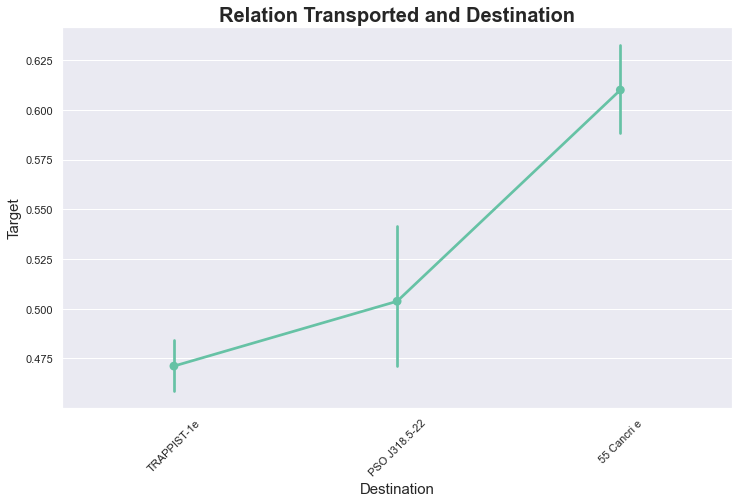

In [1334]:
plot_target_relation_cat(DESTINATION)

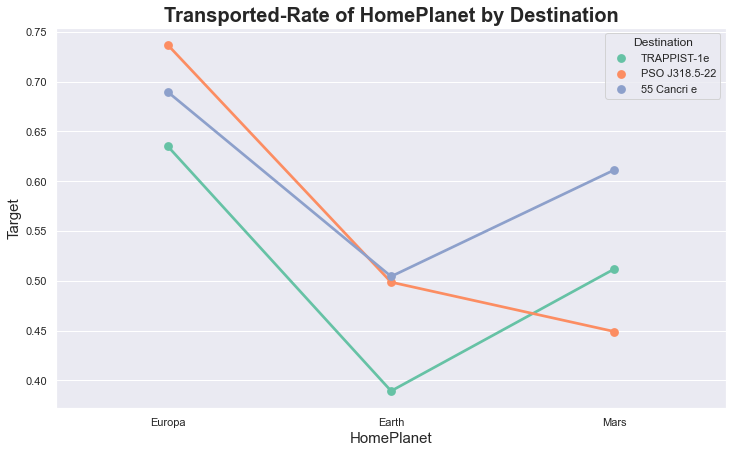

In [1335]:
sns.pointplot(x=HOME_PLANET, y=TARGET, hue=DESTINATION, ci=None, data=df).set(title="Transported-Rate of HomePlanet by Destination");

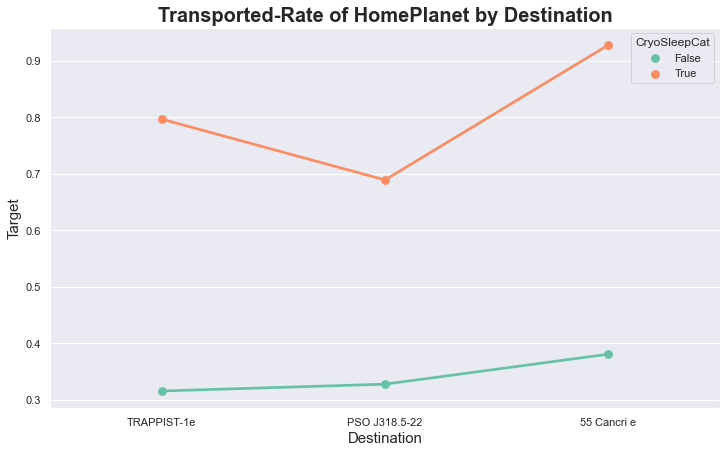

In [1336]:
sns.pointplot(x=DESTINATION, y=TARGET, hue=CRYO_SLEEP_CAT, ci=None, data=df).set(title="Transported-Rate of HomePlanet by Destination");

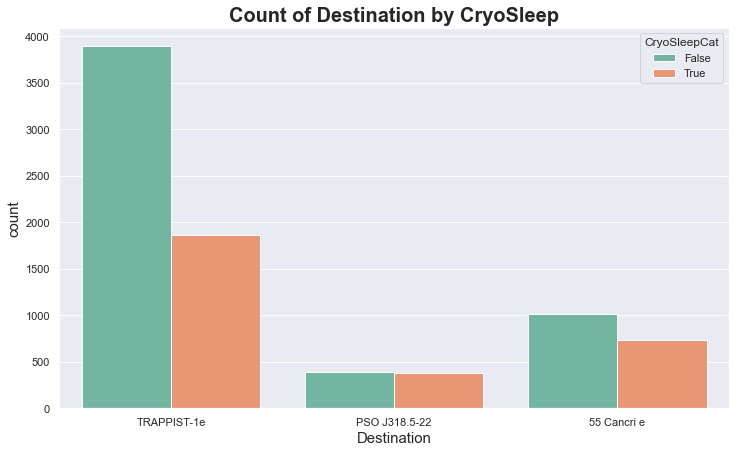

In [1337]:
sns.countplot(x=DESTINATION, hue=CRYO_SLEEP_CAT, data=df).set(title="Count of Destination by CryoSleep");

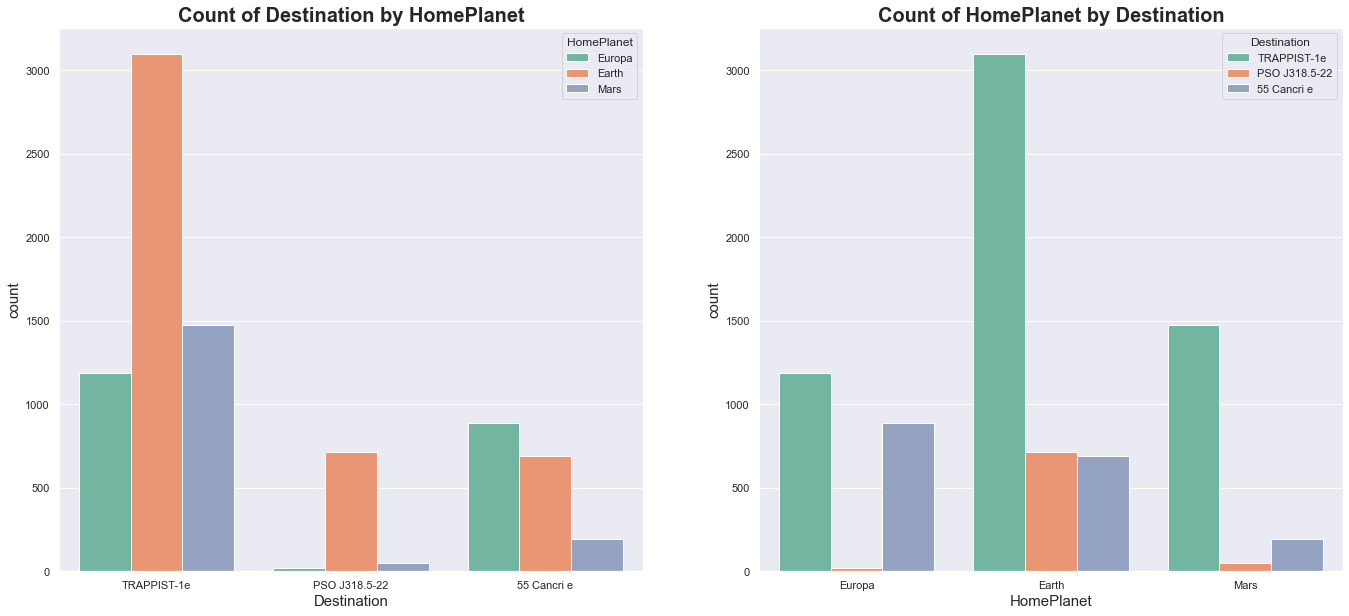

In [1338]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))
ax1, ax2 = axes

ax1.set_title("Count of Destination by HomePlanet")
ax2.set_title("Count of HomePlanet by Destination")

sns.countplot(x=DESTINATION, hue=HOME_PLANET, data=df, ax=ax1)
sns.countplot(x=HOME_PLANET, hue=DESTINATION, data=df, ax=ax2);

Notice:
- the Destination "55 Cancri e" got an significant higher Transported-Rate
- also are the most passengers which want to "55 Cancri e" from Europa (Europa got the highest Transported-Rate)

### HomePlanet by Age

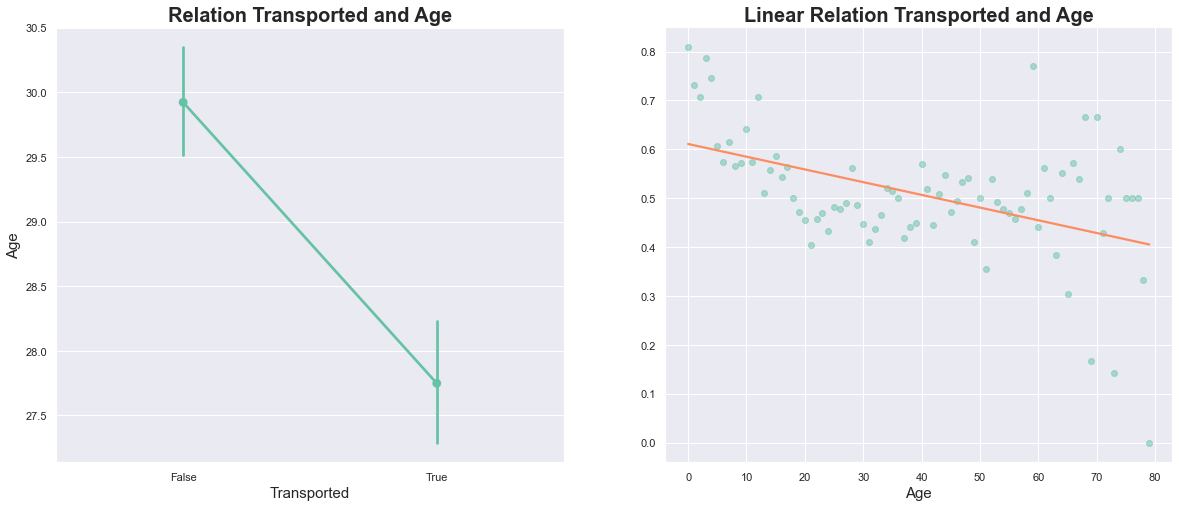

In [1339]:
plot_target_relation(AGE)

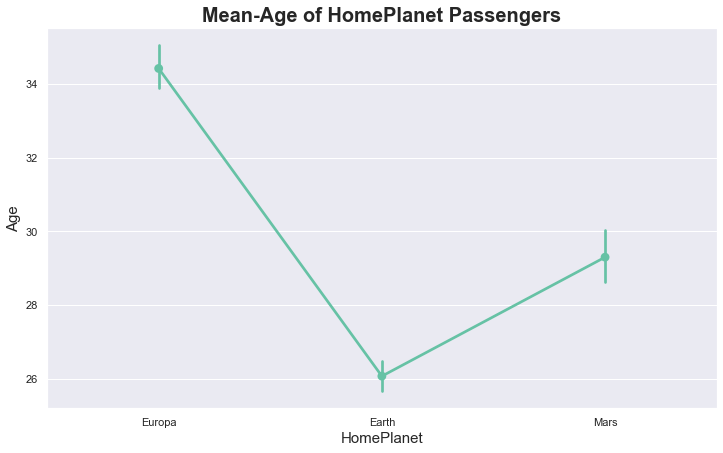

In [1340]:
sns.pointplot(x=HOME_PLANET, y=AGE, data=df).set(title="Mean-Age of HomePlanet Passengers");

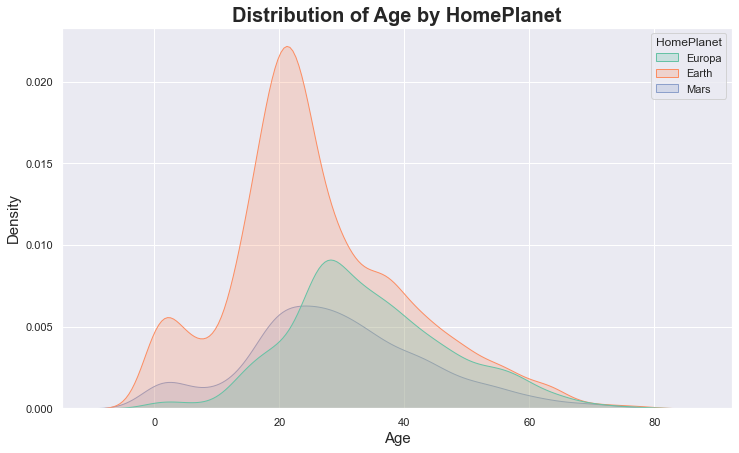

In [1341]:
sns.kdeplot(x=AGE, hue=HOME_PLANET, data=df, fill=True).set(title="Distribution of Age by HomePlanet");

Notice:
- younger Passengers got an higher Transported-Rate
- but can also recognize that the mean-age in the lowest at Earth-Passengers
- the last but: the range of the age (Plot: Relation Transported and Age) is very close with a high ci 

### HomePlanet by VIP

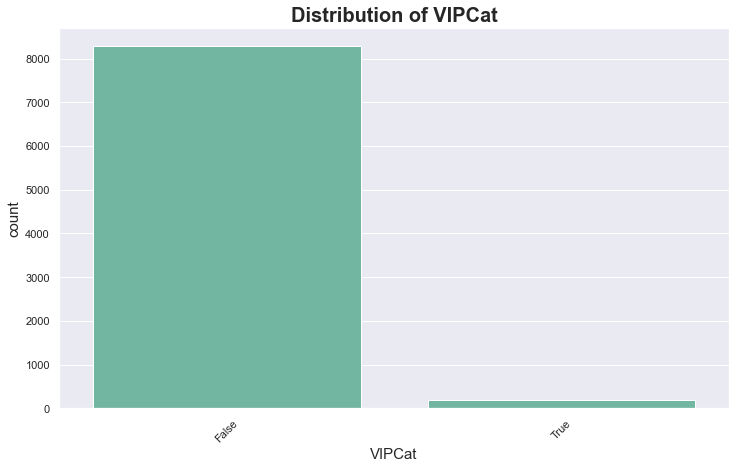

In [1342]:
plot_dist_cat(VIP_CAT)

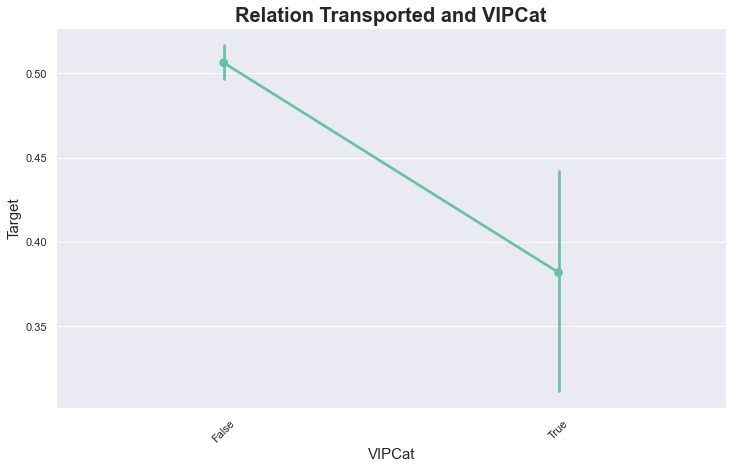

In [1343]:
plot_target_relation_cat(VIP_CAT)

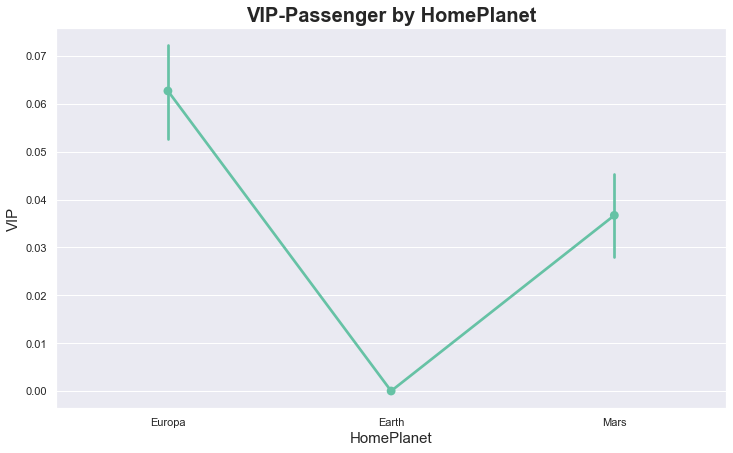

In [1344]:
sns.pointplot(x=HOME_PLANET, y=VIP, data=df).set(title="VIP-Passenger by HomePlanet");

Notice:
- More VIP-Passengers where not transported, but the ci is very high
- Also: People from Earth are never VIPs
- Most passengers are None-VIP-Passengers

### HomePlanet by Payments (RoomService, FoodCourt, ShoppingMall, Spa, VR-Deck)

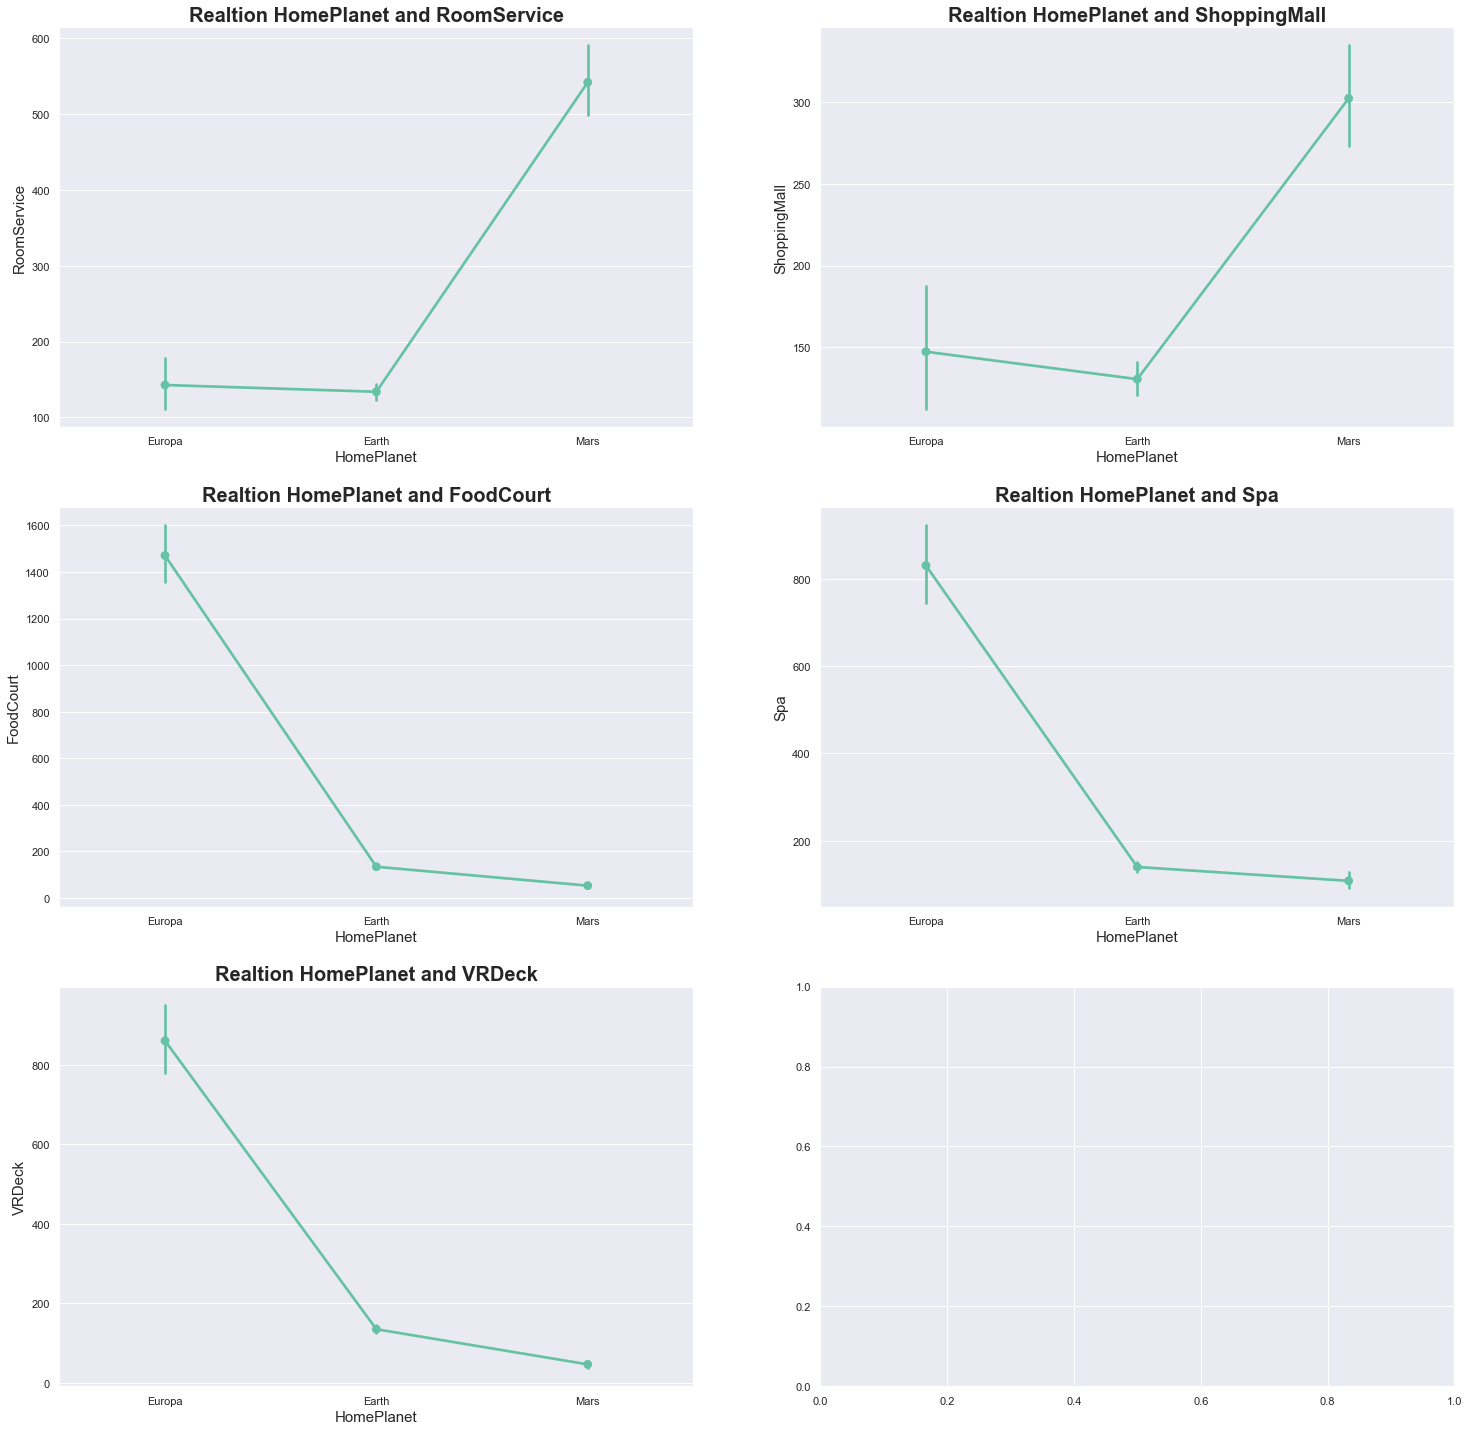

In [1345]:
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
ax5, _ = axes[2]


ax1.set_title(f"Realtion HomePlanet and {ROOM_SERVICE}")
ax2.set_title(f"Realtion HomePlanet and {SHOPPING_MALL}")
ax3.set_title(f"Realtion HomePlanet and {FOOD_COURT}")
ax4.set_title(f"Realtion HomePlanet and {SPA}")
ax5.set_title(f"Realtion HomePlanet and {VR_DECK}")

sns.pointplot(x=HOME_PLANET, y=ROOM_SERVICE, data=df, ax=ax1)
sns.pointplot(x=HOME_PLANET, y=SHOPPING_MALL, data=df, ax=ax2)
sns.pointplot(x=HOME_PLANET, y=FOOD_COURT, data=df, ax=ax3)
sns.pointplot(x=HOME_PLANET, y=SPA, data=df, ax=ax4)
sns.pointplot(x=HOME_PLANET, y=VR_DECK, data=df, ax=ax5);

Notice: <br>
We can see two patterns:
<ol>
    <li>Mars-Passengers got a significantly higher mean of RoomService and ShoppingMall</li>
    <li>Europa-Passengers got got a significantly higher mean of FoodCourt, Spa and VR-Deck</li>
</ol>

We will use these as primary interpolation features for the HomePlanet!

### Cleaning HomePlanet Feature

In [1346]:
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,False,0,False,False
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
225,NaN,0.0,F,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,False,0,False,False
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,False,0,False,False
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,False,0,False,False
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,True,1,False,NaN
8674,NaN,0.0,F,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,False,0,False,False


In [1347]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8])
)

,FoodCourt,Spa,VRDeck
0.8,94.8,93.8,96.0


,FoodCourt,Spa,VRDeck
0.8,0.0,15.0,0.0


,FoodCourt,Spa,VRDeck
0.8,2558.0,1013.0,1119.0


In [1348]:
europa_condition1 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[FOOD_COURT] > 105) | 
        (df[SPA] > 105) | 
        (df[VR_DECK] > 105)
    )
)

df.loc[europa_condition1, HOME_PLANET] = "Europa" 
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
274,NaN,1.0,G,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
286,NaN,1.0,G,PSO J318.5-22,35.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,NaN,1.0,F,TRAPPIST-1e,25.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,False,0,False,False
8674,NaN,0.0,F,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,False,0,False,False


In [1349]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8])
)

,ShoppingMall,RoomService
0.8,88.8,96.8


,ShoppingMall,RoomService
0.8,529.2,1044.2


,ShoppingMall,RoomService
0.8,0.0,0.0


In [1350]:
mars_condition1 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[SHOPPING_MALL] > 100) | 
        (df[ROOM_SERVICE] > 105)
    )
)
df.loc[mars_condition1, HOME_PLANET] = "Mars" 
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
274,NaN,1.0,G,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
286,NaN,1.0,G,PSO J318.5-22,35.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,NaN,0.0,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
8353,NaN,1.0,F,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8468,NaN,1.0,F,TRAPPIST-1e,25.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False


In [1351]:
df[(df[HOME_PLANET].isna()) & (df[TARGET] == 0)].shape,
df[(df[HOME_PLANET].isna()) & (df[TARGET] == 1)].shape

(71, 15)

Just 15 Transported over. We choose the HomePlanet of Passengers with the highest Transported-Rate, which is Europa

In [1352]:
df.loc[(df[HOME_PLANET].isna()) & (df[TARGET] == 1), HOME_PLANET] = "Europa"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
1550,NaN,1.0,NaN,55 Cancri e,18.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
1757,NaN,0.0,G,TRAPPIST-1e,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
1807,NaN,1.0,G,TRAPPIST-1e,20.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
2166,NaN,1.0,G,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
2173,NaN,1.0,G,PSO J318.5-22,57.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
2281,NaN,1.0,G,PSO J318.5-22,16.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
2290,NaN,1.0,G,TRAPPIST-1e,69.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
2642,NaN,1.0,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
3370,NaN,0.0,G,TRAPPIST-1e,29.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
3816,NaN,1.0,G,TRAPPIST-1e,21.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False


Cabin G & F + Target = 0 -> primary Earth!

In [1353]:
df.loc[df[HOME_PLANET].isna(), HOME_PLANET] = "Earth"
df[df[HOME_PLANET].isna()].shape

(0, 15)

,Target
HomePlanet,
Earth,0.422386
Europa,0.655594
Mars,0.519037


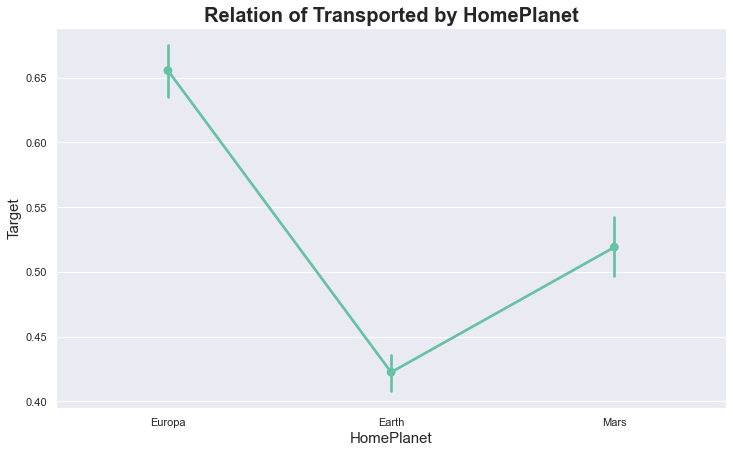

In [1354]:
sns.pointplot(x=HOME_PLANET, y=TARGET, data=df).set(title="Relation of Transported by HomePlanet")
df.pivot_table(index=HOME_PLANET, values=TARGET)

Nearly same Transported-HomePlanet distribution like before!

## Cryo Sleep

### Overview

In [1355]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
0,Europa,0.0,B,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,False,False
1,Earth,0.0,F,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,1,False,False
2,Europa,0.0,A,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False,0,False,True
3,Europa,0.0,A,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False,0,False,False
4,Earth,0.0,F,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,True,1,False,False


In [1356]:
df[CRYO_SLEEP].isna().sum()

217

In [1357]:
df[df[CRYO_SLEEP].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
92,Earth,NaN,G,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
98,Earth,NaN,F,TRAPPIST-1e,27.0,0.0,0.0,0.0,570.0,2.0,131.0,False,0,NaN,False
104,Europa,NaN,B,TRAPPIST-1e,40.0,0.0,0.0,331.0,0.0,0.0,1687.0,False,0,NaN,False
111,Mars,NaN,F,TRAPPIST-1e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
152,Earth,NaN,E,TRAPPIST-1e,58.0,0.0,0.0,985.0,0.0,5.0,0.0,True,1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,Europa,NaN,C,55 Cancri e,44.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
8651,Earth,NaN,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
8664,Earth,NaN,G,TRAPPIST-1e,32.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
8675,Earth,NaN,F,TRAPPIST-1e,44.0,0.0,1030.0,1015.0,0.0,11.0,0.0,True,1,NaN,False


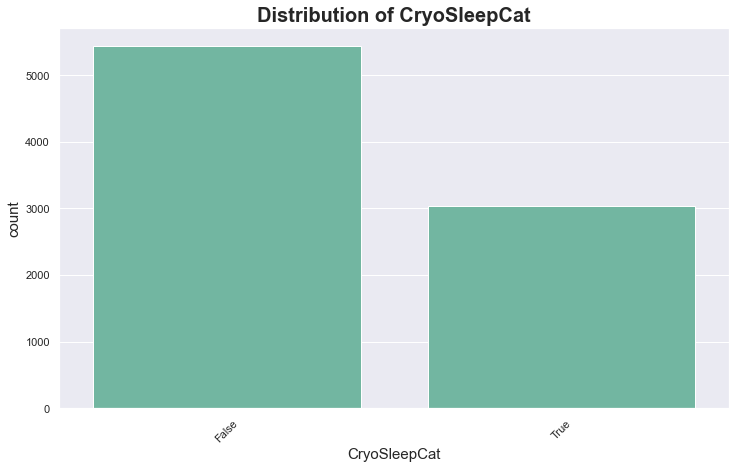

In [1358]:
plot_dist_cat(CRYO_SLEEP_CAT)

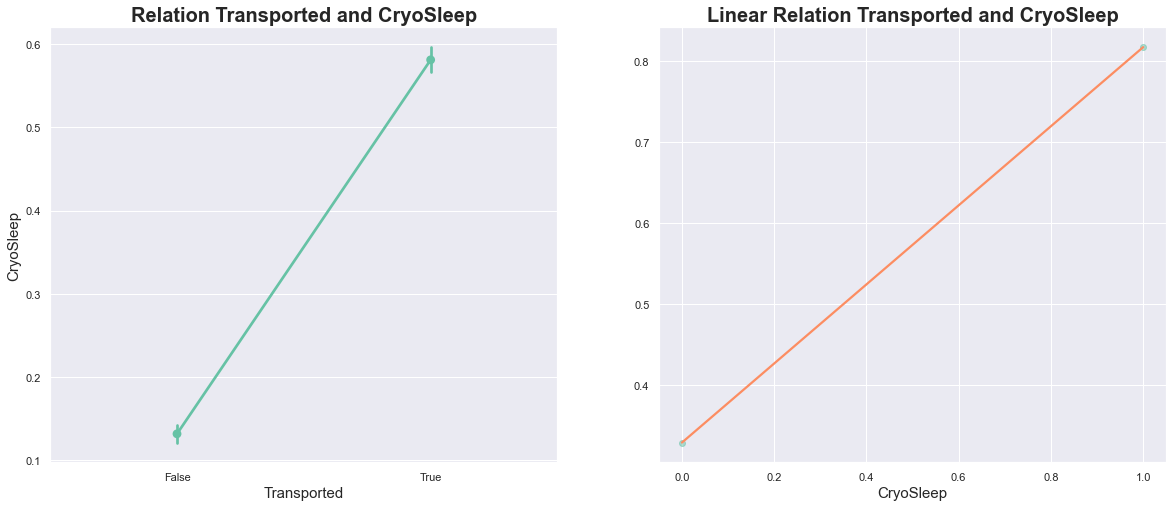

In [1359]:
plot_target_relation(CRYO_SLEEP)

Notice:
- Most Passengers are not in CryoSleep
- Passengers in CryoSleep got an significant higher Transported-Rate

### CryoSleep by HomePlanet

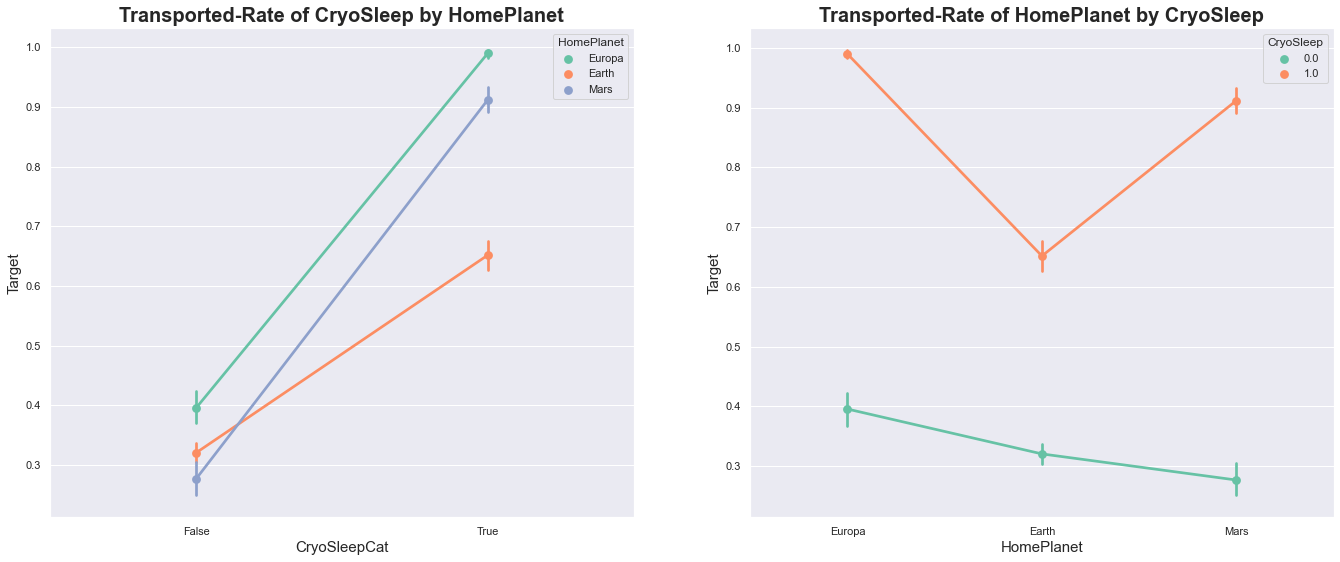

In [1360]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 9))

ax1, ax2 = axes

sns.pointplot(x=CRYO_SLEEP_CAT, y=TARGET, hue=HOME_PLANET, data=df, ax=ax1).set(title="Transported-Rate of CryoSleep by HomePlanet");
sns.pointplot(x=HOME_PLANET, y=TARGET, hue=CRYO_SLEEP, data=df, ax=ax2).set(title="Transported-Rate of HomePlanet by CryoSleep");

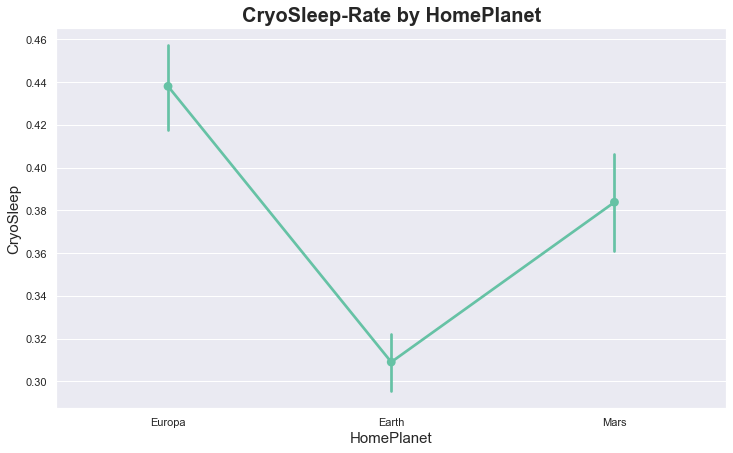

In [1361]:
sns.pointplot(x=HOME_PLANET, y=CRYO_SLEEP, data=df).set(title="CryoSleep-Rate by HomePlanet");

Notice:
- Europa got the highest CryoSleep-Rate and Earth the lowest

### CryoSleep by Cabin

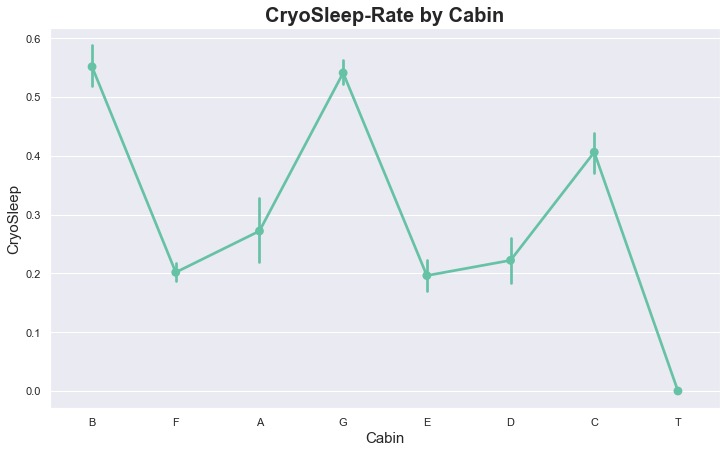

In [1362]:
sns.pointplot(x=CABIN, y=CRYO_SLEEP, data=df).set(title="CryoSleep-Rate by Cabin");

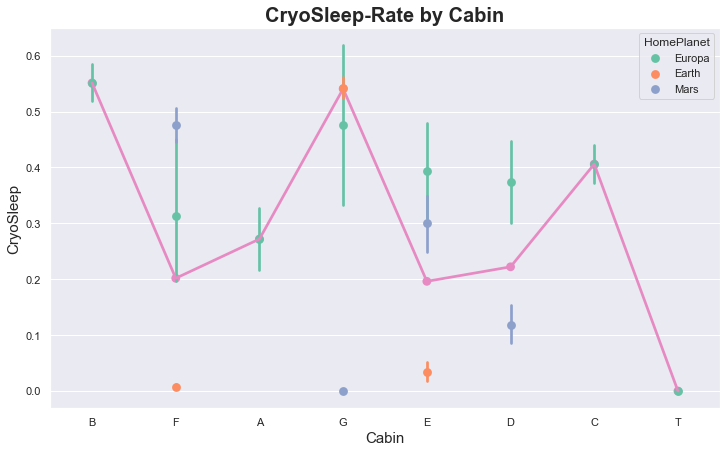

In [1363]:
sns.pointplot(x=CABIN, y=CRYO_SLEEP, color="C3", ci=None, data=df).set(title="CryoSleep-Rate by Cabin");
sns.pointplot(x=CABIN, y=CRYO_SLEEP, hue=HOME_PLANET, linestyles="", data=df).set(title="CryoSleep-Rate by Cabin");

Notice:
- Cabin B, G and C got an higher CryoSleep-Rate

### CryoSleep by Destination

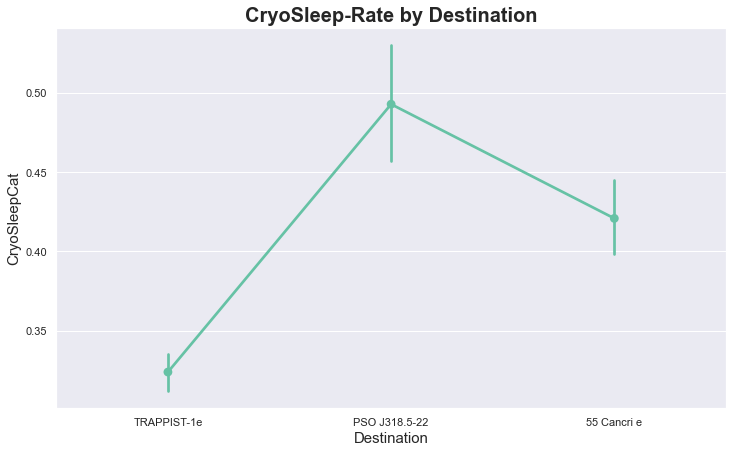

In [1364]:
sns.pointplot(x=DESTINATION, y=CRYO_SLEEP_CAT, data=df).set(title="CryoSleep-Rate by Destination");

### CryoSleep by Age

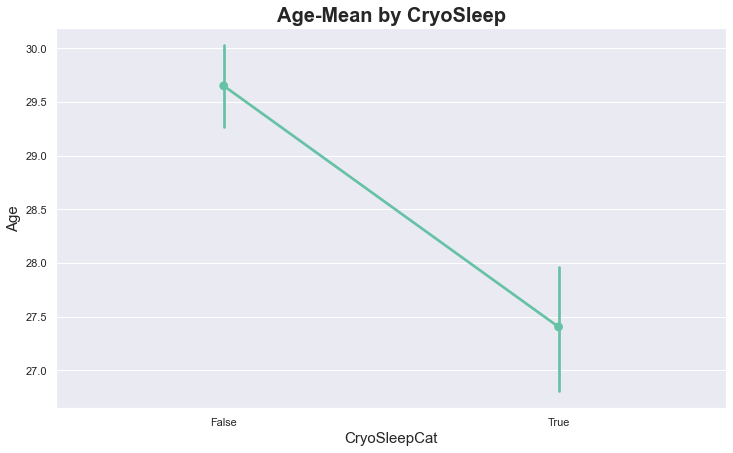

In [1365]:
sns.pointplot(x=CRYO_SLEEP_CAT, y=AGE, data=df).set(title="Age-Mean by CryoSleep");

### CryoSleep by Payments (RoomService, FoodCourt, ShoppingMall, Spa, VR-Deck) & VIP

,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
CryoSleepCat,,,,,
False,698.584299,343.000919,265.412576,475.993933,465.307961
True,0.000000,0.000000,0.000000,0.000000,0.000000


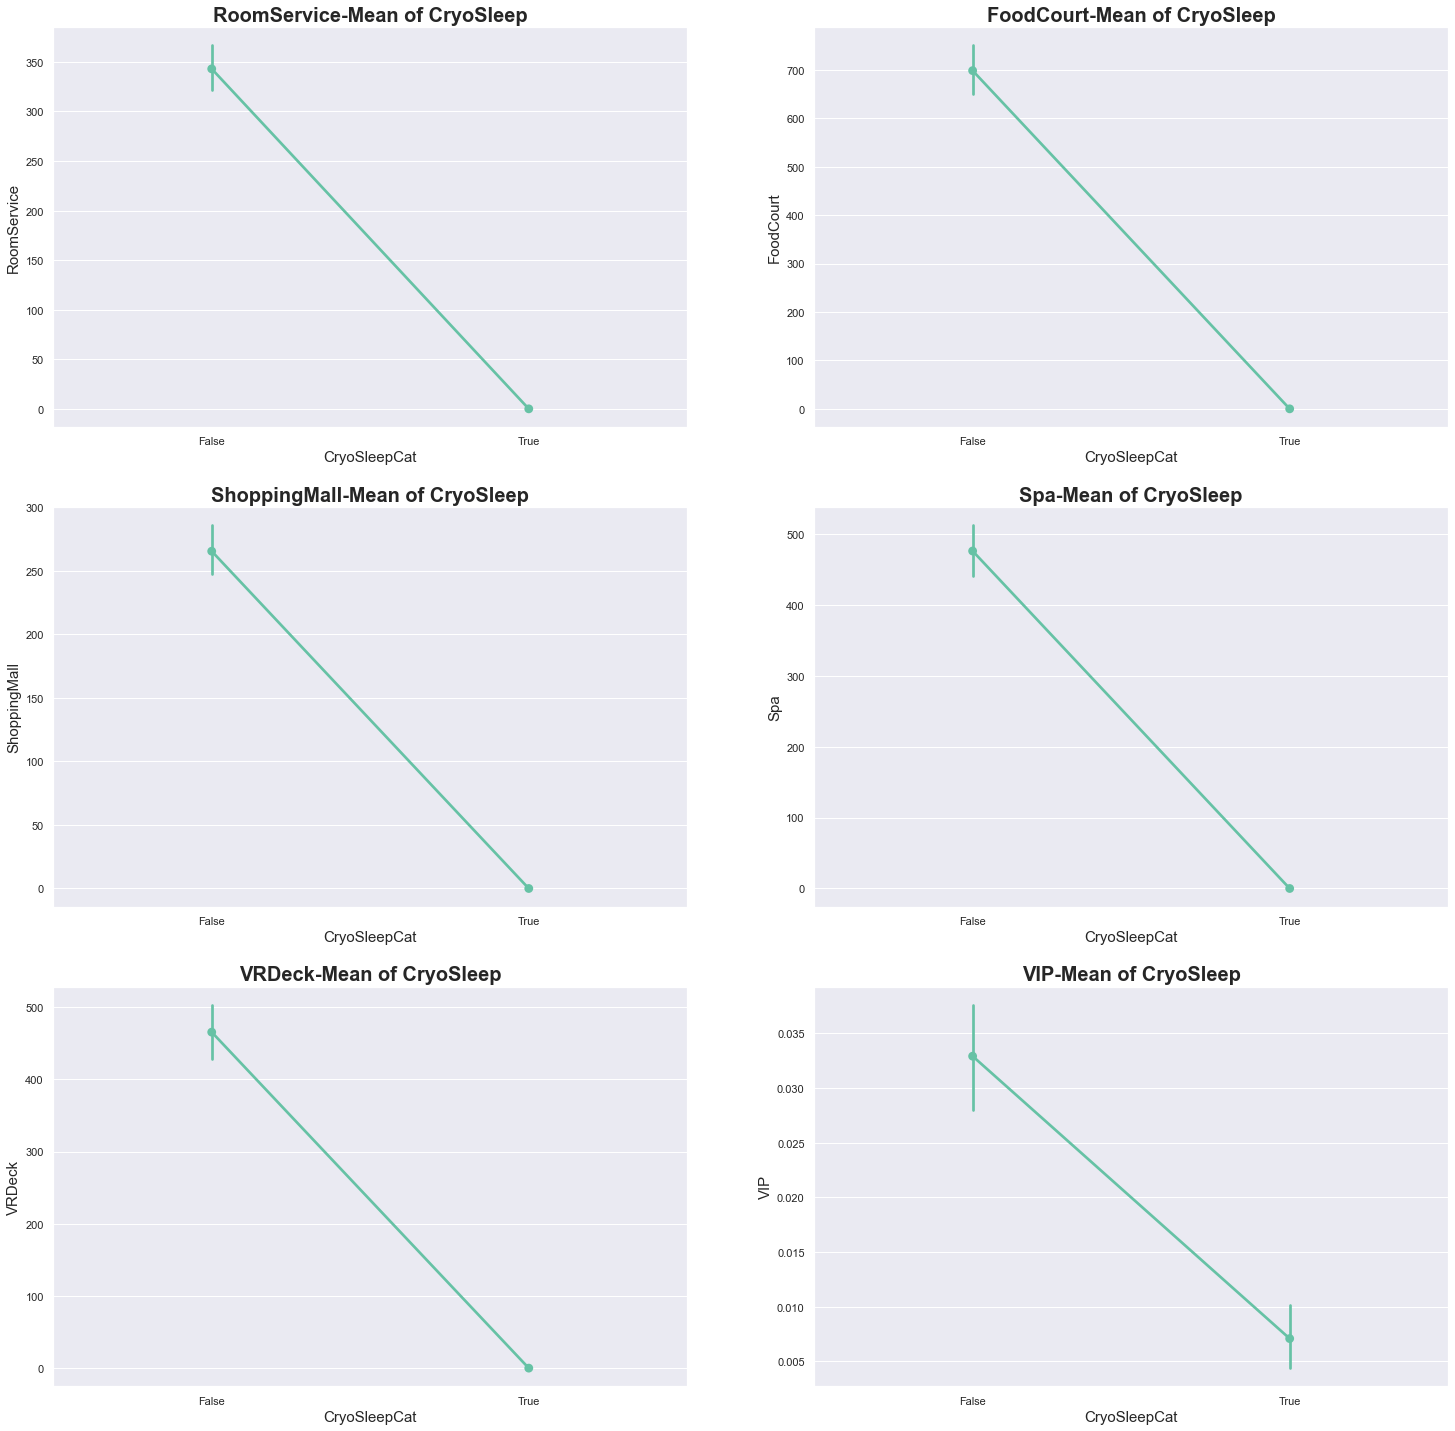

In [1366]:
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
row1, row2, row3 = axes
ax1, ax2 = row1
ax3, ax4 = row2
ax5, ax6 = row3

ax1.set_title(f"{ROOM_SERVICE}-Mean of CryoSleep")
ax2.set_title(f"{FOOD_COURT}-Mean of CryoSleep")
ax3.set_title(f"{SHOPPING_MALL}-Mean of CryoSleep")
ax4.set_title(f"{SPA}-Mean of CryoSleep")
ax5.set_title(f"{VR_DECK}-Mean of CryoSleep")
ax6.set_title(f"{VIP}-Mean of CryoSleep")

sns.pointplot(x=CRYO_SLEEP_CAT, y=ROOM_SERVICE, data=df, ax=ax1)
sns.pointplot(x=CRYO_SLEEP_CAT, y=FOOD_COURT, data=df, ax=ax2)
sns.pointplot(x=CRYO_SLEEP_CAT, y=SHOPPING_MALL, data=df, ax=ax3)
sns.pointplot(x=CRYO_SLEEP_CAT, y=SPA, data=df, ax=ax4)
sns.pointplot(x=CRYO_SLEEP_CAT, y=VR_DECK, data=df, ax=ax5)
sns.pointplot(x=CRYO_SLEEP_CAT, y=VIP, data=df, ax=ax6)

df.pivot_table(index=CRYO_SLEEP_CAT, values=[ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK])

Notice:
- If a Passenger Payed more the than 0$, this passenger is definitely not in CryoSleep

### Cleaning CryoSleep Feature

In [1367]:
df[df[CRYO_SLEEP].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
92,Earth,NaN,G,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
98,Earth,NaN,F,TRAPPIST-1e,27.0,0.0,0.0,0.0,570.0,2.0,131.0,False,0,NaN,False
104,Europa,NaN,B,TRAPPIST-1e,40.0,0.0,0.0,331.0,0.0,0.0,1687.0,False,0,NaN,False
111,Mars,NaN,F,TRAPPIST-1e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
152,Earth,NaN,E,TRAPPIST-1e,58.0,0.0,0.0,985.0,0.0,5.0,0.0,True,1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,Europa,NaN,C,55 Cancri e,44.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
8651,Earth,NaN,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
8664,Earth,NaN,G,TRAPPIST-1e,32.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
8675,Earth,NaN,F,TRAPPIST-1e,44.0,0.0,1030.0,1015.0,0.0,11.0,0.0,True,1,NaN,False


In [1368]:
pay_cols = [ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]
df.loc[df[CRYO_SLEEP] == 1, pay_cols].quantile(q=[0.99])

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0.99,0.0,0.0,0.0,0.0,0.0


In [1369]:
df.pivot_table(index=CRYO_SLEEP_CAT, values=pay_cols)

,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
CryoSleepCat,,,,,
False,698.584299,343.000919,265.412576,475.993933,465.307961
True,0.000000,0.000000,0.000000,0.000000,0.000000


In [1370]:
cryo_false_condition1 = (
    (df[CRYO_SLEEP].isna()) & 
    (
        (df[ROOM_SERVICE] > 0) |
        (df[FOOD_COURT] > 0) |
        (df[SHOPPING_MALL] > 0) |
        (df[SPA] > 0) |
        (df[VR_DECK] > 0)
    )
)

df.loc[cryo_false_condition1, CRYO_SLEEP] = 0
df[df[CRYO_SLEEP].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
92,Earth,NaN,G,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
111,Mars,NaN,F,TRAPPIST-1e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
175,Earth,NaN,G,PSO J318.5-22,52.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
266,Europa,NaN,B,TRAPPIST-1e,43.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
392,Europa,NaN,B,55 Cancri e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8501,Earth,NaN,G,TRAPPIST-1e,32.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
8612,Earth,NaN,G,PSO J318.5-22,35.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
8620,Europa,NaN,C,55 Cancri e,44.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
8651,Earth,NaN,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False


In [1371]:
# at preprocessing -> TestData with KMeans(HomePlanet, Cabin, Destination, Age)
cryo_true_condition2 = (
    (df[CRYO_SLEEP].isna()) & 
    (
        (
            (df[HOME_PLANET] == "Europa") |
            (df[HOME_PLANET] == "Mars")
        ) &
        (df[TARGET] == 1)
    )
)

df.loc[cryo_true_condition2, CRYO_SLEEP] = 1
df[df[CRYO_SLEEP].isna()].shape

(52, 15)

In [1372]:
df[df[CRYO_SLEEP].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
92,Earth,NaN,G,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
175,Earth,NaN,G,PSO J318.5-22,52.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
721,Earth,NaN,G,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
730,Earth,NaN,G,TRAPPIST-1e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
1017,Earth,NaN,G,TRAPPIST-1e,54.0,NaN,0.0,0.0,0.0,0.0,0.0,False,0,NaN,NaN
1419,Earth,NaN,G,55 Cancri e,35.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
1531,Earth,NaN,G,TRAPPIST-1e,4.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,NaN,False
2134,Earth,NaN,G,55 Cancri e,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
2226,Earth,NaN,G,TRAPPIST-1e,30.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False
2402,Earth,NaN,G,PSO J318.5-22,21.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,NaN,False


In [1373]:
cryo_true_condition3 = (
    (df[CRYO_SLEEP].isna()) & 
    (
        (df[HOME_PLANET] == "Earth") &
        (
            (df[CABIN] == "G") |
            (df[CABIN] == "B")
        ) &
        (df[TARGET] == 1)
    )
)

df.loc[cryo_true_condition3, CRYO_SLEEP] = 1
df[df[CRYO_SLEEP].isna()].shape

(29, 15)

In [1374]:
df.loc[df[CRYO_SLEEP].isna(), CRYO_SLEEP] = 0
df[CRYO_SLEEP].isna().sum()

0

In [1375]:
df[CRYO_SLEEP_CAT] = df[CRYO_SLEEP].map(TRUE_FALSE_MAP_REVERSE)
df[CRYO_SLEEP_CAT].isna().sum()

0

## Cabin

### Overview

In [1376]:
df[CABIN].isna().sum()

199

In [1377]:
df[df[CABIN].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
15,Earth,0.0,NaN,TRAPPIST-1e,31.0,0.0,32.0,0.0,876.0,0.0,0.0,False,0,False,False
93,Mars,1.0,NaN,TRAPPIST-1e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
103,Europa,0.0,NaN,TRAPPIST-1e,32.0,0.0,0.0,410.0,6.0,3929.0,764.0,False,0,False,False
222,Mars,0.0,NaN,TRAPPIST-1e,37.0,0.0,637.0,0.0,0.0,92.0,319.0,False,0,False,False
227,Mars,1.0,NaN,TRAPPIST-1e,43.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8209,Europa,0.0,NaN,55 Cancri e,53.0,0.0,0.0,1127.0,0.0,3939.0,0.0,False,0,False,False
8475,Europa,0.0,NaN,55 Cancri e,36.0,1.0,132.0,3479.0,0.0,3786.0,0.0,False,0,False,True
8485,Europa,1.0,NaN,55 Cancri e,25.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8509,Earth,1.0,NaN,TRAPPIST-1e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False


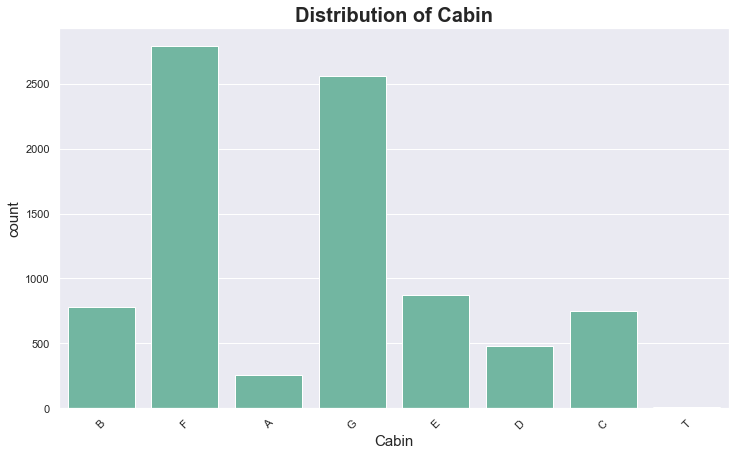

In [1378]:
plot_dist_cat(CABIN)

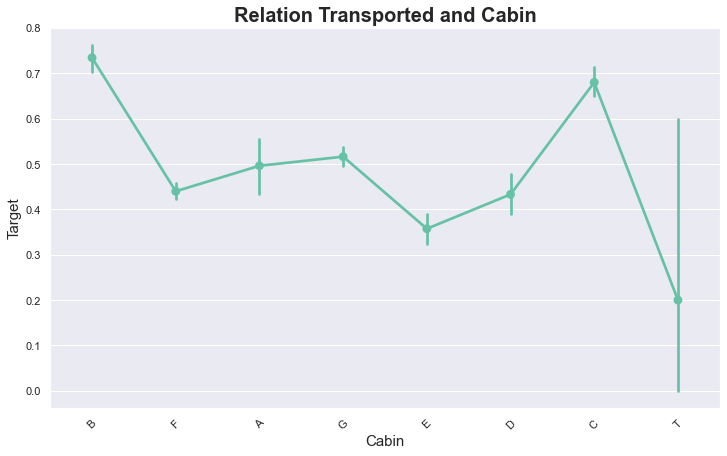

In [1379]:
plot_target_relation_cat(CABIN)

### Cabin by HomePlanet

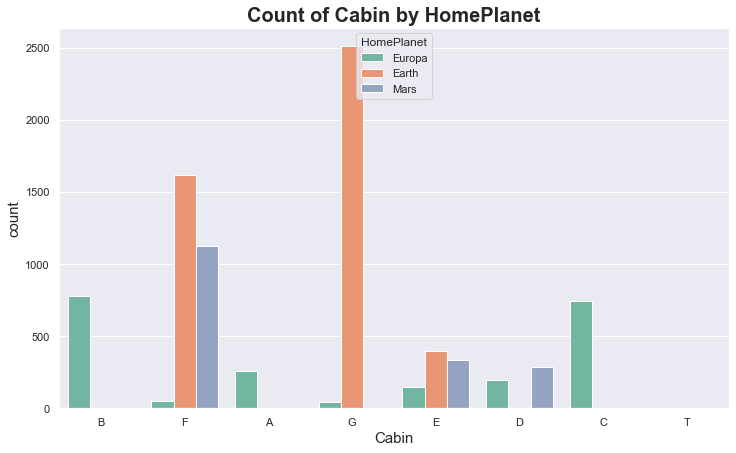

In [1380]:
sns.countplot(x=CABIN, hue=HOME_PLANET, data=df).set(title="Count of Cabin by HomePlanet");

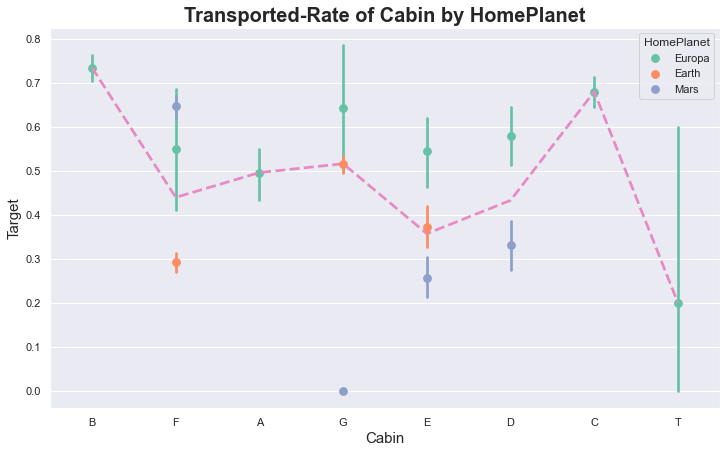

In [1381]:
sns.pointplot(x=CABIN, y=TARGET, ci=None, markers="", linestyles="--", color="C3", data=df)
sns.pointplot(x=CABIN, y=TARGET, data=df, hue=HOME_PLANET, linestyles="").set(title="Transported-Rate of Cabin by HomePlanet");

Notice:
- Cabin B & C got an higher Transported-Rate
- Cabin B, A, C is Europa only
- Cabin G Earth only

### Cleaning Cabin Feature

In [1382]:
def get_cabin(home_planet):
    match home_planet:
        case "Earth":
            rand_num = choice([0, 1, 2], p=[0.6, 0.3, 0.1])
            return "G" if rand_num == 0 else "F" if rand_num == 1 else "E"
        case "Europa":
            rand_num = choice([0, 1, 2, 3], p=[0.4, 0.4, 0.1, 0.1])
            return "B" if rand_num == 0 else "C" if rand_num == 1 else "A" if rand_num == 2 else "D"
        case _:
            rand_num = choice([0, 1, 2], p=[0.8, 0.11, 0.09])
            return "F" if rand_num == 0 else "E" if rand_num == 1 else "D"

In [1383]:
is_cabin_na = (df[CABIN].isna())
df.loc[is_cabin_na, CABIN] = df.loc[is_cabin_na, HOME_PLANET].apply(get_cabin)
df[df[CABIN].isna()].shape

(0, 15)

In [1384]:
df[CABIN].value_counts()

F    2857
G    2615
E     886
B     807
C     770
D     489
A     264
T       5
Name: Cabin, dtype: int64

## Destination

### Overview

In [1385]:
df[DESTINATION].isna().sum()

182

In [1386]:
df[df[DESTINATION].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
47,Mars,1.0,F,NaN,19.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
128,Earth,0.0,E,NaN,34.0,0.0,0.0,22.0,0.0,564.0,207.0,False,0,False,False
139,Earth,0.0,F,NaN,41.0,0.0,0.0,0.0,0.0,0.0,607.0,False,0,False,False
347,Europa,0.0,G,NaN,23.0,0.0,348.0,0.0,0.0,4.0,368.0,False,0,False,False
430,Earth,1.0,G,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,Earth,1.0,G,NaN,20.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8551,Mars,1.0,F,NaN,41.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8616,Mars,1.0,F,NaN,33.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8621,Europa,0.0,C,NaN,41.0,1.0,0.0,7964.0,0.0,3238.0,5839.0,False,0,False,True


In [1387]:
df.isna().sum()

HomePlanet        0
CryoSleep         0
Cabin             0
Destination     182
Age             179
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Target            0
CryoSleepCat      0
VIPCat          203
dtype: int64

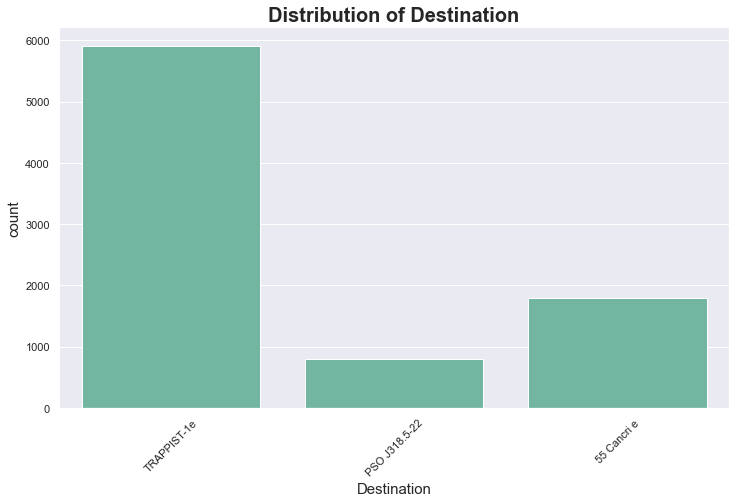

In [1388]:
plot_dist_cat(DESTINATION)

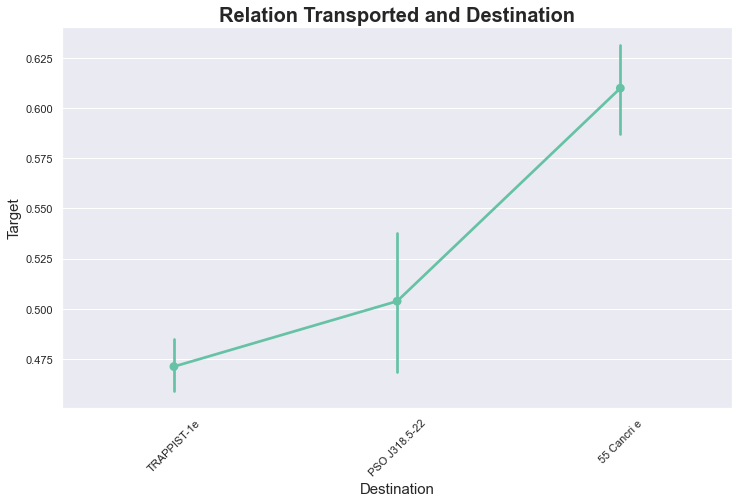

In [1389]:
plot_target_relation_cat(DESTINATION)

Notice:
-  TRAPPIST-1e is the most Destination Target

### Destination by HomePlanet

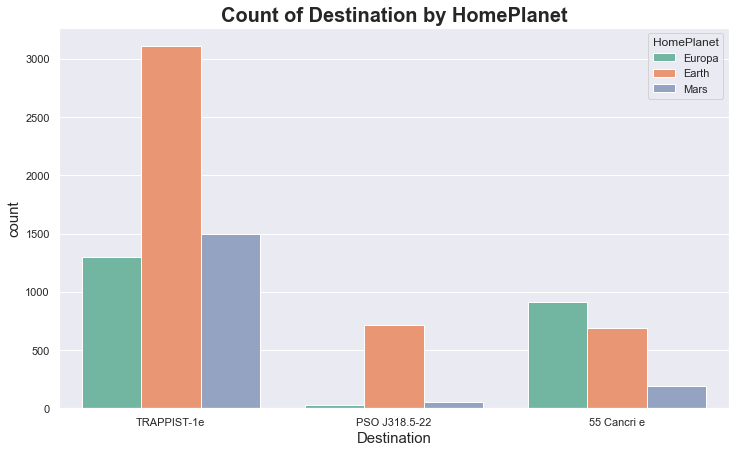

In [1390]:
sns.countplot(x=DESTINATION, hue=HOME_PLANET, data=df).set(title="Count of Destination by HomePlanet");

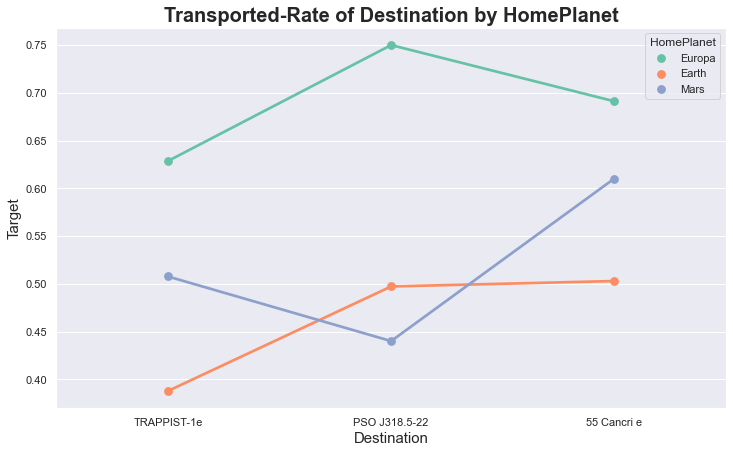

In [1391]:
sns.pointplot(x=DESTINATION, y=TARGET, hue=HOME_PLANET, ci=None, data=df).set(title="Transported-Rate of Destination by HomePlanet");

Notice:
- Destination PSO J318.5-22 is strongly dominated by Earth-Passengers

### Destination by CryoSleep

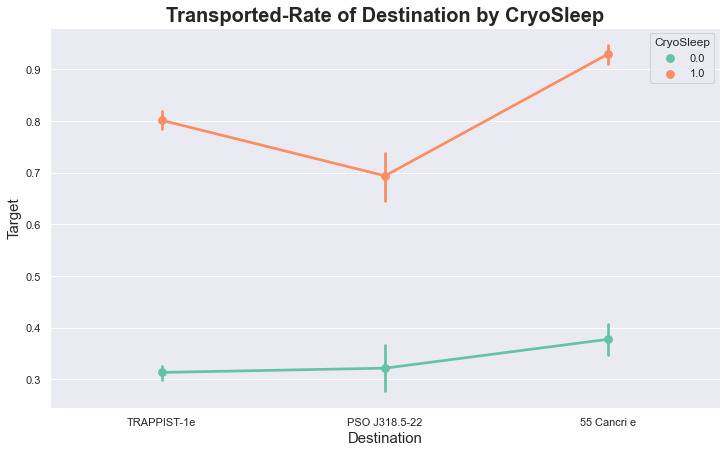

In [1392]:
sns.pointplot(x=DESTINATION, y=TARGET, hue=CRYO_SLEEP, data=df).set(title="Transported-Rate of Destination by CryoSleep");

Notice:
- Most Earth-Passengers aren't in CryoSleep. And the PSO J318.5-22 is dominated by Earth-Passengers

### Clean Destination Feature

In [1393]:
df[DESTINATION].fillna(df[DESTINATION].mode()[0], inplace=True)
df[DESTINATION].isna().sum()

0

## Age

### Overview

In [1394]:
df[AGE].isna().sum()

179

In [1395]:
df[df[AGE].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat
50,Earth,0.0,G,TRAPPIST-1e,NaN,0.0,4.0,0.0,2.0,4683.0,0.0,False,0,False,False
64,Mars,0.0,E,TRAPPIST-1e,NaN,0.0,793.0,0.0,2.0,253.0,0.0,False,0,False,False
137,Earth,1.0,G,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
181,Europa,0.0,A,55 Cancri e,NaN,0.0,0.0,2433.0,0.0,878.0,443.0,True,1,False,False
184,Europa,0.0,C,55 Cancri e,NaN,0.0,2.0,1720.0,12.0,1125.0,122.0,True,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8274,Earth,1.0,G,TRAPPIST-1e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True,False
8301,Europa,1.0,C,TRAPPIST-1e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False
8374,Earth,0.0,G,TRAPPIST-1e,NaN,0.0,194.0,1.0,10.0,629.0,0.0,False,0,False,False
8407,Earth,1.0,G,TRAPPIST-1e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,True,1,True,False


Skew: 	 0.41909658301471536


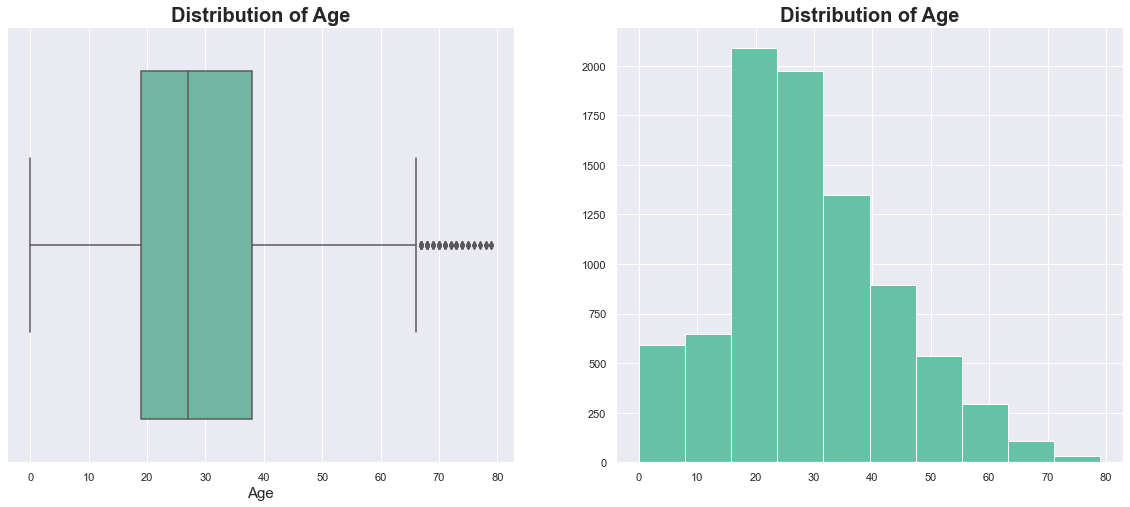

In [1396]:
plot_dist(AGE)

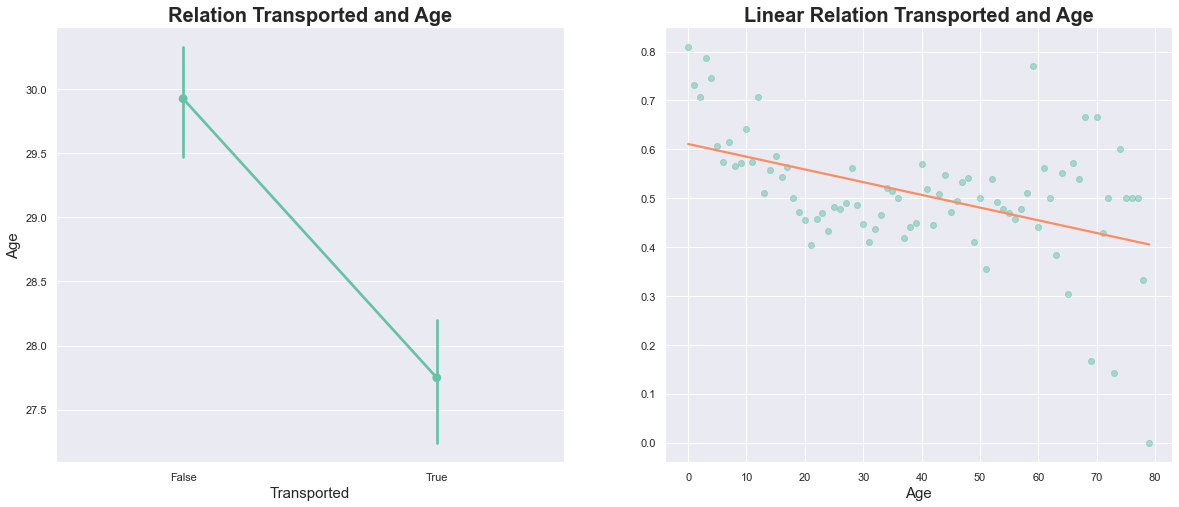

In [1397]:
plot_target_relation(AGE)

Notice:
- Younger Passengers got an higher Transported-Rate

### Age by HomePlanet

[(25.0, 35.0), Text(0.5, 1.0, 'Age-Mean of HomePlanet')]

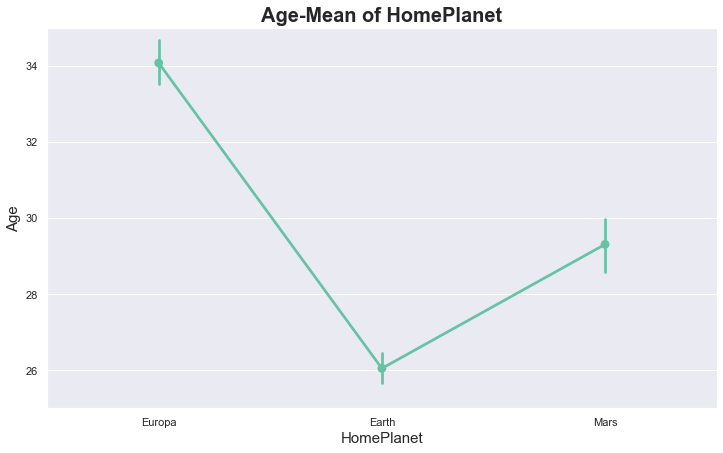

In [1398]:
sns.pointplot(x=HOME_PLANET, y=AGE, data=df).set(ylim=(25, 35), title="Age-Mean of HomePlanet")

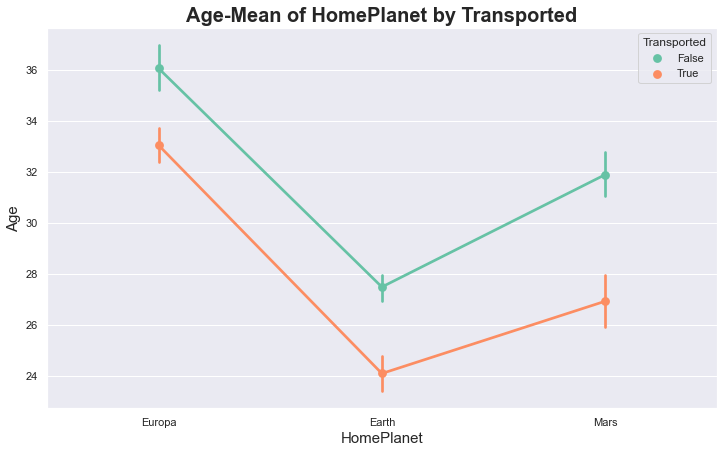

In [1399]:
sns.pointplot(x=HOME_PLANET, y=AGE, hue=TARGET_TRANSPORTED, data=df).set(title="Age-Mean of HomePlanet by Transported");

Notice:
- Europa-Passengers are older and Earth-Passengers are younger

### Age by CryoSleep

In [1400]:
df[CRYO_SLEEP_CAT]

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689     True
8690    False
8691    False
8692    False
Name: CryoSleepCat, Length: 8693, dtype: bool

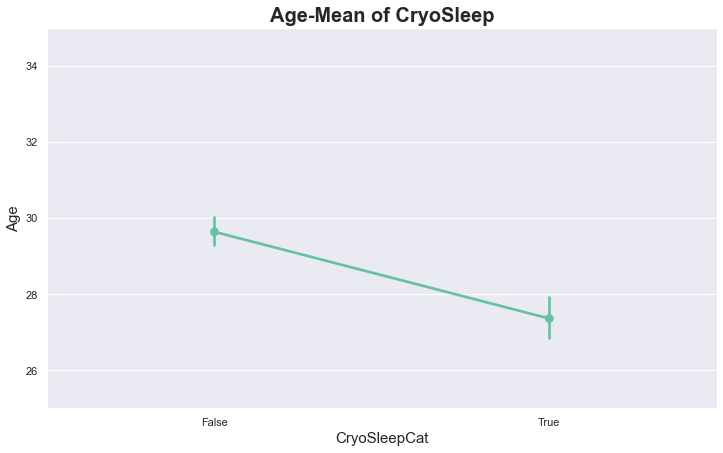

In [1401]:
sns.pointplot(x=CRYO_SLEEP_CAT, y=AGE, data=df).set(ylim=(25, 35), title="Age-Mean of CryoSleep");

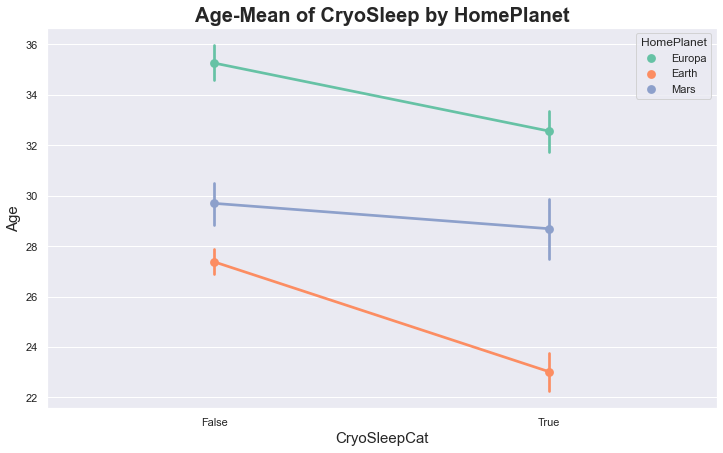

In [1402]:
sns.pointplot(x=CRYO_SLEEP_CAT, y=AGE, hue=HOME_PLANET, data=df).set(title="Age-Mean of CryoSleep by HomePlanet");

Notice:
- Younger Passengers where more in CryoSleep, but there is not significant difference

### Cleaning Age Feature

In [1403]:
age_by_home_planet_map = df.pivot_table(index=HOME_PLANET, values=AGE, aggfunc="median").to_dict()[AGE]
is_age_na = (df[AGE].isna())

df.loc[is_age_na, AGE] = df.loc[is_age_na, HOME_PLANET].map(age_by_home_planet_map)
df[AGE].isna().sum()

0

## VIP

### Overview

In [1404]:
df[VIP].isna().sum()

203

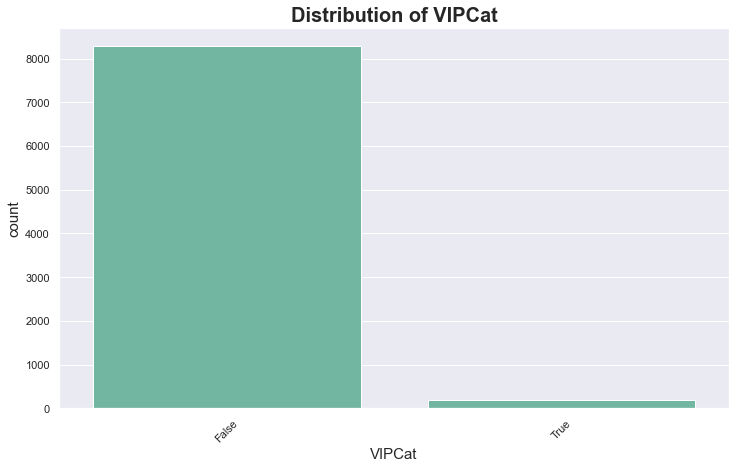

In [1405]:
plot_dist_cat(VIP_CAT)

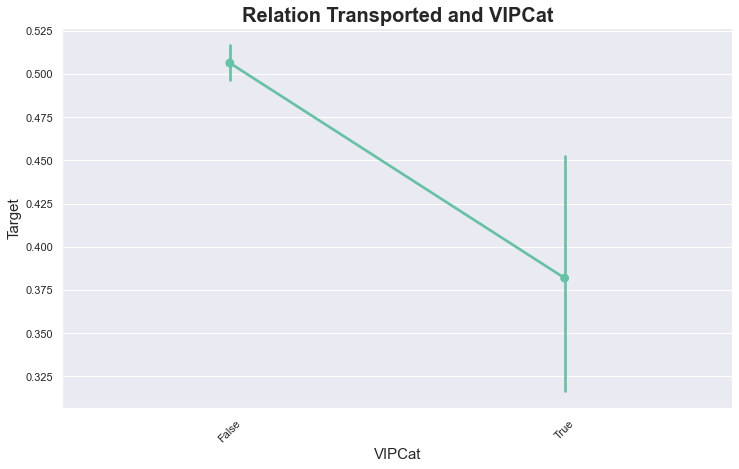

In [1406]:
plot_target_relation_cat(VIP_CAT)

Notice:
- the absolute majority is no VIP-Passenger!

### VIP by HomePlanet

,VIP
HomePlanet,
Earth,0.000000
Europa,0.059296
Mars,0.037866


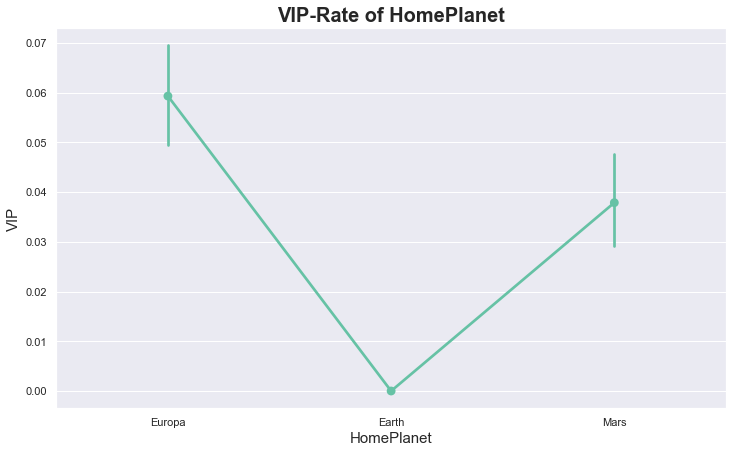

In [1407]:
sns.pointplot(x=HOME_PLANET, y=VIP, data=df).set(title="VIP-Rate of HomePlanet")
df.pivot_table(index=HOME_PLANET, values=VIP)

Notice:
- Earth-Passengers are never VIP-Passengers

### VIP by CryoSleep

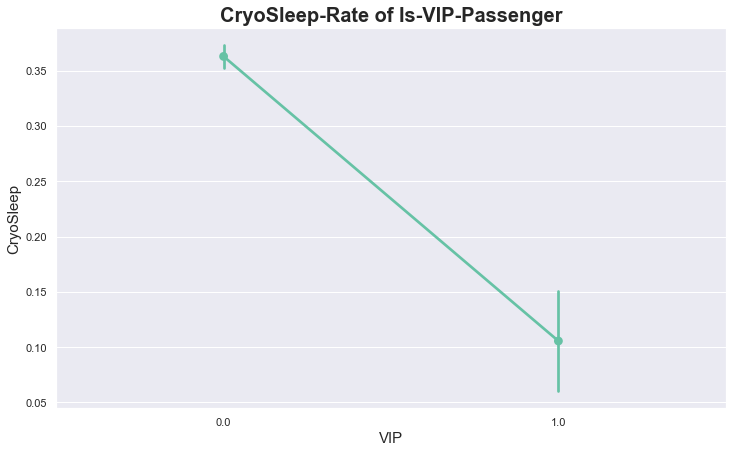

In [1408]:
sns.pointplot(x=VIP, y=CRYO_SLEEP, data=df).set(title="CryoSleep-Rate of Is-VIP-Passenger");

### VIP by Payments (RoomService, FoodCourt, ShoppingMall, Spa, VR-Deck)

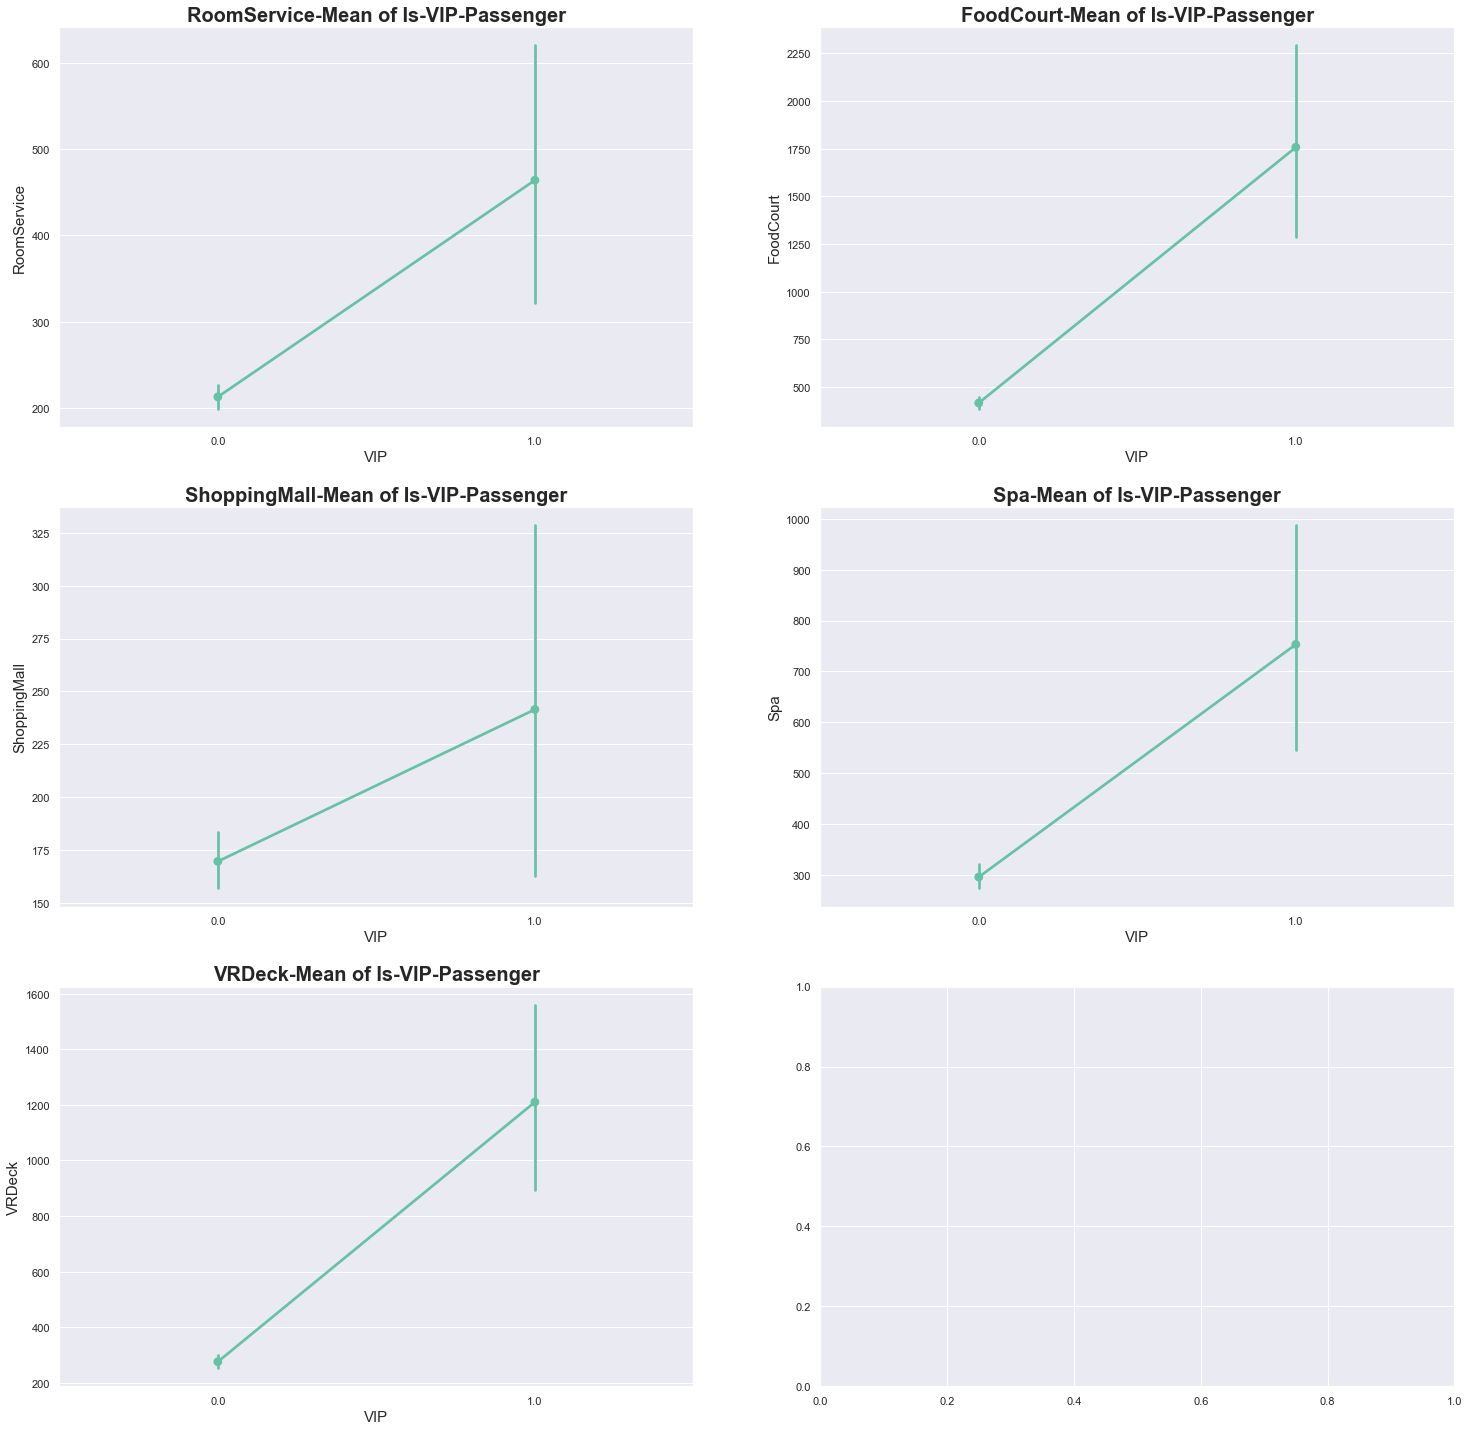

In [1409]:
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
row1, row2, row3 = axes
ax1, ax2 = row1
ax3, ax4 = row2
ax5, _ = row3

ax1.set_title(f"{ROOM_SERVICE}-Mean of Is-VIP-Passenger")
ax2.set_title(f"{FOOD_COURT}-Mean of Is-VIP-Passenger")
ax3.set_title(f"{SHOPPING_MALL}-Mean of Is-VIP-Passenger")
ax4.set_title(f"{SPA}-Mean of Is-VIP-Passenger")
ax5.set_title(f"{VR_DECK}-Mean of Is-VIP-Passenger")

sns.pointplot(x=VIP, y=ROOM_SERVICE, data=df, ax=ax1)
sns.pointplot(x=VIP, y=FOOD_COURT, data=df, ax=ax2)
sns.pointplot(x=VIP, y=SHOPPING_MALL, data=df, ax=ax3)
sns.pointplot(x=VIP, y=SPA, data=df, ax=ax4)
sns.pointplot(x=VIP, y=VR_DECK, data=df, ax=ax5);

,Payments
VIPCat,
False,1371.504644
True,4425.477387


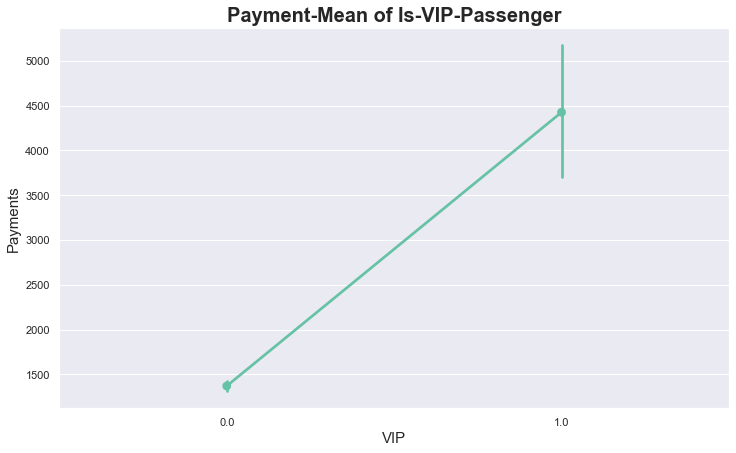

In [1410]:
payment_sum = df[[ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]].sum(axis=1)
tmp_vip_payment_df = DataFrame({VIP: df[VIP], VIP_CAT: df[VIP_CAT], PAYMENTS: payment_sum})

sns.pointplot(x=VIP, y=PAYMENTS, data=tmp_vip_payment_df).set(title="Payment-Mean of Is-VIP-Passenger")
tmp_vip_payment_df.pivot_table(index=VIP_CAT, values=PAYMENTS, aggfunc="mean")

Notice:
-  The higher the Payments are, the higher is the VIP-Rate

### Cleaning VIP Feature

In [1411]:
df[PAYMENTS] = df[[ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]].sum(axis=1)
df[PAYMENTS]

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: Payments, Length: 8693, dtype: float64

In [1412]:
df.loc[(df[VIP].isna()) & (df[HOME_PLANET] == "Earth"), VIP] = 0

In [1413]:
df.loc[(df[VIP].isna()) & (df[PAYMENTS] > 1500)] = 1

In [1414]:
df[df[VIP].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat,Payments
145,Mars,1.0,F,TRAPPIST-1e,35.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
228,Mars,1.0,F,55 Cancri e,14.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
596,Europa,1.0,C,TRAPPIST-1e,39.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
678,Europa,1.0,A,55 Cancri e,25.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
942,Europa,1.0,A,55 Cancri e,56.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
1001,Mars,1.0,F,TRAPPIST-1e,28.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0
1116,Mars,0.0,F,TRAPPIST-1e,23.0,NaN,60.0,1356.0,0.0,0.0,0.0,True,1,False,NaN,1416.0
1134,Mars,0.0,F,TRAPPIST-1e,28.0,NaN,42.0,1116.0,0.0,0.0,0.0,True,1,False,NaN,1158.0
1431,Mars,0.0,E,TRAPPIST-1e,32.0,NaN,1240.0,0.0,58.0,0.0,0.0,False,0,False,NaN,1298.0
1464,Europa,1.0,B,55 Cancri e,51.0,NaN,0.0,0.0,0.0,0.0,0.0,True,1,True,NaN,0.0


In [1415]:
df[VIP] = df[VIP].fillna(0).astype("int")
df[VIP_CAT] = df[VIP].map(TRUE_FALSE_MAP_REVERSE)
df[VIP].isna().sum()

0

In [1416]:
df.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Target          0
CryoSleepCat    0
VIPCat          0
Payments        0
dtype: int64

In [1417]:
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Target,CryoSleepCat,VIPCat,Payments
0,Europa,0.0,B,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,False,False,0.0
1,Earth,0.0,F,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,True,1,False,False,736.0
2,Europa,0.0,A,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,False,True,10383.0
3,Europa,0.0,A,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,False,False,5176.0
4,Earth,0.0,F,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,True,1,False,False,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0.0,A,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,False,0,False,True,8536.0
8689,Earth,1.0,G,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,False,0,True,False,0.0
8690,Earth,0.0,G,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,True,1,False,False,1873.0
8691,Europa,0.0,E,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,False,0,False,False,4637.0
